Experimentando pipeline splade da aula 8 no contexto da aula 10 (computational tradeoffs)


[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


naver/splade_v2_distil (do distilbert) ou splade-cocondenser-selfdistil (do BERT-base 110M params)

 https://arxiv.org/pdf/2205.04733.pdf

# Organizando o ambiente

In [1]:
import pickle

In [2]:
import math

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import gzip

In [6]:
import statistics


In [7]:
import time

In [8]:
import shutil

In [9]:
import json

In [10]:
import pandas as pd

In [11]:
from tqdm import tqdm

In [12]:
from transformers import  BatchEncoding

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from torch.nn.functional import relu

In [14]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

In [15]:
from evaluate import load

In [16]:
trec_eval = load("trec_eval")

In [17]:
trec_eval = load("trec_eval")

In [18]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/tradeoff'
DIRETORIO_RUN = f"{DIRETORIO_TRABALHO}/runs"
DIRETORIO_TREC_COVID = F'{DIRETORIO_LOCAL}/trec_covid'

In [19]:
CAMINHO_ARQUIVO_EXPANSAO_MAX = f"{DIRETORIO_TRABALHO}/expansao_corpus_max.pickle"

In [20]:
CAMINHO_ARQUIVO_EXPANSAO_MAX_SEM_SEP = f"{DIRETORIO_TRABALHO}/expansao_corpus_max_sem_sep.pickle"

In [21]:
if os.path.exists(DIRETORIO_LOCAL):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_LOCAL)
    print('pasta criada!')


pasta já existia!


In [22]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta já existia!


In [23]:
if os.path.exists(DIRETORIO_TREC_COVID):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TREC_COVID)
    print('pasta criada!')


pasta já existia!


In [24]:
DIRETORIO_RUN = f"{DIRETORIO_TRABALHO}/runs"
CAMINHO_RUN = f"{DIRETORIO_RUN}/run-trec-covid.txt"

In [25]:
if os.path.exists(DIRETORIO_RUN):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_RUN)
    print('pasta criada!')


pasta já existia!


In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  

In [27]:
from psutil import virtual_memory

In [28]:
def mostra_memoria(lista_mem=['cpu']):
  """
  Esta função exibe informações de memória da CPU e/ou GPU, conforme parâmetros fornecidos.

  Parâmetros:
  -----------
  lista_mem : list, opcional
      Lista com strings 'cpu' e/ou 'gpu'. 
      'cpu' - exibe informações de memória da CPU.
      'gpu' - exibe informações de memória da GPU (se disponível).
      O valor padrão é ['cpu'].

  Saída:
  -------
  A função não retorna nada, apenas exibe as informações na tela.

  Exemplo de uso:
  ---------------
  Para exibir informações de memória da CPU:
      mostra_memoria(['cpu'])

  Para exibir informações de memória da CPU e GPU:
      mostra_memoria(['cpu', 'gpu'])
  
  Autor: Marcus Vinícius Borela de Castro

  """  
  if 'cpu' in lista_mem:
    vm = virtual_memory()
    ram={}
    ram['total']=round(vm.total / 1e9,2)
    ram['available']=round(virtual_memory().available / 1e9,2)
    # ram['percent']=round(virtual_memory().percent / 1e9,2)
    ram['used']=round(virtual_memory().used / 1e9,2)
    ram['free']=round(virtual_memory().free / 1e9,2)
    ram['active']=round(virtual_memory().active / 1e9,2)
    ram['inactive']=round(virtual_memory().inactive / 1e9,2)
    ram['buffers']=round(virtual_memory().buffers / 1e9,2)
    ram['cached']=round(virtual_memory().cached/1e9 ,2)
    print(f"Your runtime RAM in gb: \n total {ram['total']}\n available {ram['available']}\n used {ram['used']}\n free {ram['free']}\n cached {ram['cached']}\n buffers {ram['buffers']}")
    print('/nGPU')
    gpu_info = !nvidia-smi
  if 'gpu' in lista_mem:
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)


In [29]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 61.7
 used 4.71
 free 50.54
 cached 10.97
 buffers 1.14
/nGPU
Sun May 14 20:17:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   51C    P8    30W / 370W |     60MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

## Fixando as seeds

In [30]:
import random
import torch
import numpy as np

In [31]:
def inicializa_seed(num_semente:int=123):
  """
  Inicializa as sementes para garantir a reprodutibilidade dos resultados do modelo.
  Essa é uma prática recomendada, já que a geração de números aleatórios pode influenciar os resultados do modelo.
  Além disso, a função também configura as sementes da GPU para garantir a reprodutibilidade quando se utiliza aceleração por GPU. 
  
  Args:
      num_semente (int): número da semente a ser utilizada para inicializar as sementes das bibliotecas.
  
  References:
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  # Define as sementes das bibliotecas random, numpy e pytorch
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  
  # Define as sementes da GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True


In [32]:
num_semente=123
inicializa_seed(num_semente)

## Preparando para debug e display

In [33]:
import pandas as pd

In [34]:
import transformers

In [35]:
def config_display():
  """
  Esta função configura as opções de display do Pandas.
  """

  # Configurando formato saída Pandas
  # define o número máximo de colunas que serão exibidas
  pd.options.display.max_columns = None

  # define a largura máxima de uma linha
  pd.options.display.width = 1000

  # define o número máximo de linhas que serão exibidas
  pd.options.display.max_rows = 100

  # define o número máximo de caracteres por coluna
  pd.options.display.max_colwidth = 50

  # se deve exibir o número de linhas e colunas de um DataFrame.
  pd.options.display.show_dimensions = True

  # número de dígitos após a vírgula decimal a serem exibidos para floats.
  pd.options.display.precision = 7


In [36]:
def config_debug():
  """
  Esta função configura as opções de debug do PyTorch e dos pacotes
  transformers e datasets.
  """

  # Define opções de impressão de tensores para o modo científico
  torch.set_printoptions(sci_mode=True) 
  """
    Significa que valores muito grandes ou muito pequenos são mostrados em notação científica.
    Por exemplo, em vez de imprimir o número 0.0000012345 como 0.0000012345, 
    ele seria impresso como 1.2345e-06. Isso é útil em situações em que os valores dos tensores 
    envolvidos nas operações são muito grandes ou pequenos, e a notação científica permite 
    uma melhor compreensão dos números envolvidos.  
  """

  # Habilita detecção de anomalias no autograd do PyTorch
  torch.autograd.set_detect_anomaly(True)
  """
    Permite identificar operações que podem causar problemas de estabilidade numérica, 
    como gradientes explodindo ou desaparecendo. Quando essa opção é ativada, 
    o PyTorch verifica se há operações que geram valores NaN ou infinitos nos tensores 
    envolvidos no cálculo do gradiente. Se for detectado um valor anômalo, o PyTorch 
    interrompe a execução e gera uma exceção, permitindo que o erro seja corrigido 
    antes que se torne um problema maior.

    É importante notar que a detecção de anomalias pode ter um impacto significativo 
    no desempenho, especialmente em modelos grandes e complexos. Por esse motivo,
    ela deve ser usada com cautela e apenas para depuração.
  """

  # Configura variável de ambiente para habilitar a execução síncrona (bloqueante) das chamadas da API do CUDA.
  os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  """
    o Python aguarda o término da execução de uma chamada da API do CUDA antes de executar a próxima chamada. 
    Isso é útil para depurar erros no código que envolve operações na GPU, pois permite que o erro seja capturado 
    no momento em que ocorre, e não depois de uma sequência de operações que pode tornar a origem do erro mais difícil de determinar.
    No entanto, é importante lembrar que esse modo de execução é significativamente mais lento do que a execução assíncrona, 
    que é o comportamento padrão do CUDA. Por isso, é recomendado utilizar esse comando apenas em situações de depuração 
    e removê-lo após a solução do problema.
  """

  # Define o nível de verbosity do pacote transformers para info
  # transformers.utils.logging.set_verbosity_info() 
  
  
  """
    Define o nível de detalhamento das mensagens de log geradas pela biblioteca Hugging Face Transformers 
    para o nível info. Isso significa que a biblioteca irá imprimir mensagens de log informativas sobre
    o andamento da execução, tais como tempo de execução, tamanho de batches, etc.

    Essas informações podem ser úteis para entender o que está acontecendo durante a execução da tarefa 
    e auxiliar no processo de debug. É importante notar que, em alguns casos, a quantidade de informações
    geradas pode ser muito grande, o que pode afetar o desempenho do sistema e dificultar a visualização
    das informações relevantes. Por isso, é importante ajustar o nível de detalhamento de acordo com a 
    necessidade de cada tarefa.
  
    Caso queira reduzir a quantidade de mensagens, comentar a linha acima e 
      descomentar as duas linhas abaixo, para definir o nível de verbosity como error ou warning
  
    transformers.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_warning()
  """


  # Define o modo verbose do xmode, que é utilizado no debug
  # %xmode Verbose 

  """
    Comando usado no Jupyter Notebook para controlar o modo de exibição das informações de exceções.
    O modo verbose é um modo detalhado que exibe informações adicionais ao imprimir as exceções.
    Ele inclui as informações de pilha de chamadas completa e valores de variáveis locais e globais 
    no momento da exceção. Isso pode ser útil para depurar e encontrar a causa de exceções em seu código.
    Ao usar %xmode Verbose, as informações de exceção serão impressas com mais detalhes e informações adicionais serão incluídas.

    Caso queira desabilitar o modo verbose e utilizar o modo plain, 
    comentar a linha acima e descomentar a linha abaixo:
    %xmode Plain
  """

  """
    Dica:
    1.  pdb (Python Debugger)
      Quando ocorre uma exceção em uma parte do código, o programa para a execução e exibe uma mensagem de erro 
      com informações sobre a exceção, como a linha do código em que ocorreu o erro e o tipo da exceção.

      Se você estiver depurando o código e quiser examinar o estado das variáveis ​​e executar outras operações 
      no momento em que a exceção ocorreu, pode usar o pdb (Python Debugger). Para isso, é preciso colocar o comando %debug 
      logo após ocorrer a exceção. Isso fará com que o programa pare na linha em que ocorreu a exceção e abra o pdb,
      permitindo que você explore o estado das variáveis, examine a pilha de chamadas e execute outras operações para depurar o código.


    2. ipdb
      O ipdb é um depurador interativo para o Python que oferece recursos mais avançados do que o pdb,
      incluindo a capacidade de navegar pelo código fonte enquanto depura.
      
      Você pode começar a depurar seu código inserindo o comando ipdb.set_trace() em qualquer lugar do 
      seu código onde deseja pausar a execução e começar a depurar. Quando a execução chegar nessa linha, 
      o depurador entrará em ação, permitindo que você examine o estado atual do seu programa e execute 
      comandos para investigar o comportamento.

      Durante a depuração, você pode usar comandos:
        next (para executar a próxima linha de código), 
        step (para entrar em uma função chamada na próxima linha de código) 
        continue (para continuar a execução normalmente até o próximo ponto de interrupção).

      Ao contrário do pdb, o ipdb é um depurador interativo que permite navegar pelo código fonte em que
      está trabalhando enquanto depura, permitindo que você inspecione variáveis, defina pontos de interrupção
      adicionais e até mesmo execute expressões Python no contexto do seu programa.
  """


In [37]:
config_display()

In [38]:
config_debug()

# Baixando o dataset para avaliação (trec-covid)

## Queries

In [39]:
os.environ['JVM_PATH'] = '/usr/lib/jvm/java-11-openjdk-amd64/lib/server/libjvm.so'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

In [40]:
from pyserini.search import get_topics

In [41]:
topics = get_topics('covid-round5')
print(f'{len(topics)} queries total')

50 queries total


In [42]:
topics[50]

{'question': 'what is known about an mRNA vaccine for the SARS-CoV-2 virus?',
 'query': 'mRNA vaccine coronavirus',
 'narrative': 'Looking for studies specifically focusing on mRNA vaccines for COVID-19, including how mRNA vaccines work, why they are promising, and any results from actual clinical studies.'}

## Relevância (qrel) de teste

In [43]:
if not os.path.exists(f'{DIRETORIO_TREC_COVID}/test.tsv'):
    !wget https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv
    !mv test.tsv {DIRETORIO_LOCAL}/
else:
    print('Arquivo já existia')

Arquivo já existia


In [44]:
qrel = pd.read_csv(f"{DIRETORIO_TREC_COVID}/test.tsv", sep="\t", header=None, 
                   skiprows=1, names=["query", "docid", "rel"])

In [45]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [46]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [47]:
qrel["q0"] = "q0"
qrel_dict = qrel.to_dict(orient="list")

In [48]:
qrel_dict['query'][0], qrel_dict['docid'][0], qrel_dict['rel'][0]

(1, '005b2j4b', 2)

# Carregando modelo e tokenizador splade 

modelo 'naver/splade-cocondenser-ensembledistil' 

In [ ]:
PATH_NOME_MODELO = "naver/splade-cocondenser-ensembledistil"

In [ ]:
# Se tiver que treinar os modelos, abre
model = BertForMaskedLM.from_pretrained(PATH_NOME_MODELO).to(device)

In [ ]:
print(model.config)

BertConfig {
  "_name_or_path": "naver/splade-cocondenser-ensembledistil",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
tokenizer = BertTokenizer.from_pretrained(PATH_NOME_MODELO)

In [ ]:
print(tokenizer.model_max_length)

512


In [ ]:
sentences_test = ["He likes to eat pizza in the pizza hut.", "So many sentences are transformed in just a summary."]

In [ ]:
    # Tokenize sentences
encoded_input = tokenizer(sentences_test,
                                add_special_tokens=True,
                                return_special_tokens_mask=True, 
                                padding=True, 
                                truncation=True,
                                max_length=model.config.max_position_embeddings,
                                return_tensors='pt')

In [ ]:
 # ' '.join(tokenizer.tokenize(sentences_test[0]))

[tokenizer.tokenize(sentence) for sentence in sentences_test]

[['he', 'likes', 'to', 'eat', 'pizza', 'in', 'the', 'pizza', 'hut', '.'],
 ['so',
  'many',
  'sentences',
  'are',
  'transformed',
  'in',
  'just',
  'a',
  'summary',
  '.']]

# Carregando documentos a serem indexados

Outra opção é acessar por load_dataset

        from datasets import load_dataset
        dataset_corpus = load_dataset("BeIR/trec-covid", "corpus")
        dataset_corpus

In [ ]:
import string

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punctuation = text.translate(translator)
    return text_without_punctuation

# Exemplo de uso
texto = "Olá, mundo! Isso é um exemplo."
texto_sem_pontuacao = remove_punctuation(texto)

print(texto_sem_pontuacao)

Olá mundo Isso é um exemplo


In [49]:
if not os.path.exists(f"{DIRETORIO_TREC_COVID}/corpus.jsonl.gz"):
    !wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
    !mv corpus.jsonl.gz {DIRETORIO_TREC_COVID}
    print('Baixado')
else:
    print('Já existia a pasta')

Já existia a pasta


In [99]:
# Descompacte o arquivo para a memória
with gzip.open(f'{DIRETORIO_TREC_COVID}/corpus.jsonl.gz', 'rt') as f:
    # Leia o conteúdo do arquivo descompactado
    corpus = [json.loads(line) for line in f]

In [100]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} corpus[0] {corpus[0]}" )

<class 'list'> len(corpus): 171332 corpus[0] {'_id': 'ug7v899j', 'title': 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia', 'text': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%

Ordenar Corpus para tornar mais ágil a inferência

Alterado código para salvar o texto tokenizado para carga posterior no lucene

In [158]:
%%time
cnt=0
corpus_sem_vazios = []
for docto in tqdm(corpus):
    if ('title' in docto) and len(docto['title']) >= 5:
        texto_usado_na_geracao_de_query = docto['title'] + '. ' + docto['text']
    else:
        texto_usado_na_geracao_de_query = docto['text']
    #corpus_dict[docto['_id']] = {'text_query_generation': texto_usado_na_geracao_de_query, 
    #                             'title': docto['title'],
    #                             'text': docto['text']}
    docto['texto_titulo'] = texto_usado_na_geracao_de_query
    # Excluindo textos vazios, pois splade gera tokens mesmo para textos vazios por causa dos tokens especiais
    if len(docto['texto_titulo']) <= 10:
        cnt += 1
    else:
        docto['texto_titulo'] = texto_usado_na_geracao_de_query
        docto['texto_titulo_tokenizado'] = ' '.join(tokenizer.tokenize(remove_punctuation(texto_usado_na_geracao_de_query)))
        corpus_sem_vazios.append(docto)


100%|██████████| 171184/171184 [05:36<00:00, 508.75it/s]

CPU times: user 5min 36s, sys: 364 ms, total: 5min 36s
Wall time: 5min 36s


In [159]:
cnt

0

In [160]:
corpus = sorted(corpus_sem_vazios, key=lambda x: len(x['texto_titulo']))

In [161]:
del corpus_sem_vazios

In [162]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} corpus[0] {corpus[0]}" )

<class 'list'> len(corpus): 171184 corpus[0] {'_id': 'u09rn09u', 'title': 'ABSTRACTS', 'text': '', 'metadata': {'url': 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1495151/', 'pubmed_id': '11972737'}, 'texto_titulo': 'ABSTRACTS. ', 'texto_titulo_tokenizado': 'abstracts'}


In [163]:
# Exiba os dados carregados
print(f"{corpus[300]}" )

{'_id': '0rw0qq7z', 'title': 'Strange days', 'text': '', 'metadata': {'url': '', 'pubmed_id': ''}, 'texto_titulo': 'Strange days. ', 'texto_titulo_tokenizado': 'strange days'}


In [164]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} corpus[200] {corpus[200]}" )

<class 'list'> len(corpus): 171184 corpus[200] {'_id': 'na37g4ht', 'title': 'BAT RABIES.', 'text': '', 'metadata': {'url': 'https://www.ncbi.nlm.nih.gov/pubmed/24544638/', 'pubmed_id': '24544638'}, 'texto_titulo': 'BAT RABIES.. ', 'texto_titulo_tokenizado': 'bat ra ##bies'}


In [165]:
lista_doc_id_passage = [doc['_id'] for doc in corpus]
print(f"len(lista_doc_id_passage) {len(lista_doc_id_passage)}")

len(lista_doc_id_passage) 171184


In [166]:
corpus_dict = {}

for docto in corpus:
    corpus_dict[docto['_id']] = {'texto_titulo': docto['texto_titulo']}

In [167]:
corpus_dict_tokenizado = {}

for docto in corpus:
    corpus_dict_tokenizado[docto['_id']] = {'texto_titulo_tokenizado': docto['texto_titulo_tokenizado']}

In [168]:
len(corpus_dict)

171184

tamanho original 171332

# Experimentos de teste de encoding

In [72]:
print(encoded_input)

{'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [73]:
# print(f"padded_batch {padded_batch}")
encoded_input = BatchEncoding(encoded_input)
print('após BatchEncoding',encoded_input)

após BatchEncoding {'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [74]:
encoded_input['input_ids'].shape[1]

12

In [75]:
# Move os dados para o dispositivo especificado (CPU ou GPU)
encoded_input_cuda = {key: value.to(device) for key, value in encoded_input.items()}
print(encoded_input)

{'input_ids': tensor([[  101,  2002,  7777,  2000,  4521, 10733,  1999,  1996, 10733, 12570,
          1012,   102],
        [  101,  2061,  2116, 11746,  2024,  8590,  1999,  2074,  1037, 12654,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [76]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**{k:v for k,v in encoded_input_cuda.items() if k != 'special_tokens_mask'})

In [77]:
model_output.keys()

odict_keys(['logits'])

In [78]:
model_output.logits.shape

torch.Size([2, 12, 30522])

In [79]:
logits = model_output.logits.cpu()

In [80]:
assert logits.shape[0]== len(sentences_test), f"logits.shape[0] deveria ser igual a len(sentences_test), mas {logits.shape[0]} != {len(sentences_test)}"

In [81]:
assert logits.shape[2]== model.config.vocab_size, f"logits.shape[2] deveria ser igual model.config.vocab_size, mas {logits.shape[2]} != {model.config.vocab_size}  "

In [82]:
assert logits.shape[1] ==  encoded_input['input_ids'].shape[1], f"logits.shape[1] ==  encoded_input['input_ids'].shape[1], mas {logits.shape[1]} != {encoded_input['input_ids'].shape[1]}"

In [83]:
logits

tensor([[[-6.3893e+00, -8.2711e+00, -7.5464e+00,  ..., -8.2343e+00, -7.9853e+00, -6.5540e+00],
         [-1.0677e+01, -1.0912e+01, -1.0080e+01,  ..., -1.1239e+01, -1.0584e+01, -1.0340e+01],
         [-1.4504e+01, -1.3984e+01, -1.2138e+01,  ..., -1.3341e+01, -1.2841e+01, -1.3440e+01],
         ...,
         [-1.1762e+01, -1.0844e+01, -9.7184e+00,  ..., -1.0512e+01, -9.5783e+00, -1.1487e+01],
         [-2.0236e+01, -1.6708e+01, -1.5875e+01,  ..., -1.6253e+01, -1.5220e+01, -1.7133e+01],
         [-1.8771e+01, -1.5834e+01, -1.5056e+01,  ..., -1.5429e+01, -1.4388e+01, -1.6011e+01]],

        [[-6.0462e+00, -8.0102e+00, -7.5297e+00,  ..., -7.4065e+00, -7.7055e+00, -6.0488e+00],
         [-7.0161e+00, -8.8562e+00, -8.1384e+00,  ..., -8.3108e+00, -8.6692e+00, -6.5108e+00],
         [-9.4267e+00, -1.0151e+01, -9.3825e+00,  ..., -9.5120e+00, -9.9987e+00, -7.8468e+00],
         ...,
         [-2.0250e+01, -1.6809e+01, -1.7290e+01,  ..., -1.6032e+01, -1.6992e+01, -1.9700e+01],
         [-1.8281e+0

In [84]:
logits_relu = relu(logits)

In [85]:
logits_relu.shape

torch.Size([2, 12, 30522])

In [86]:
indices_nao_zero = torch.nonzero(logits_relu)

In [87]:
indices_nao_zero.shape

torch.Size([248, 3])

In [88]:
for i in range(logits_relu.shape[0]):
    indices = indices_nao_zero[i]
    print(f"Indices não nulos para a amostra {i}:")
    print(indices)

Indices não nulos para a amostra 0:
tensor([   0,    0, 2002])
Indices não nulos para a amostra 1:
tensor([   0,    0, 2010])


In [89]:
print(indices_nao_zero[:3])

tensor([[   0,    0, 2002],
        [   0,    0, 2010],
        [   0,    0, 2032]])


In [90]:

num_splits = 2  # dividir indices_nao_zero em duas partes
batch_size = indices_nao_zero.shape[0] // num_splits  # indices_nao_zero.shape[0]

splits = torch.split(indices_nao_zero, batch_size, dim=0)

for i, split in enumerate(splits):
    # encontre os valores não-zero correspondentes em logits_relu para esta parte de indices_nao_zero
    values = logits_relu[split[:, 0], split[:, 1], split[:, 2]]
    print(f"Valores para a parte {i}: {values[:3]}")

Valores para a parte 0: tensor([1.4559e+00, 9.9054e-01, 6.2091e-01])
Valores para a parte 1: tensor([1.2144e+00, 2.6016e-01, 3.4094e-02])


In [91]:
valores = logits_relu[indices_nao_zero[:, 0], indices_nao_zero[:, 1], indices_nao_zero[:, 2]]

In [92]:
print(valores.shape, valores[:3])

torch.Size([248]) tensor([1.4559e+00, 9.9054e-01, 6.2091e-01])


## Usando "sum"

In [85]:
wj_sum = torch.sum(torch.log(1 + relu(logits)), dim=1)

In [86]:
wj_sum.shape

torch.Size([2, 30522])

In [87]:
wj_sum_sparse = wj_sum.to_sparse()

In [88]:
type(wj_sum_sparse), wj_sum_sparse.shape

(torch.Tensor, torch.Size([2, 30522]))

In [89]:
wj_sum_sparse

tensor(indices=tensor([[    0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     0,     0,
                            0,     0,     0,     0,     0,     0,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,     1,     1,     1,     1,     1,     1,
                            1,     1,   

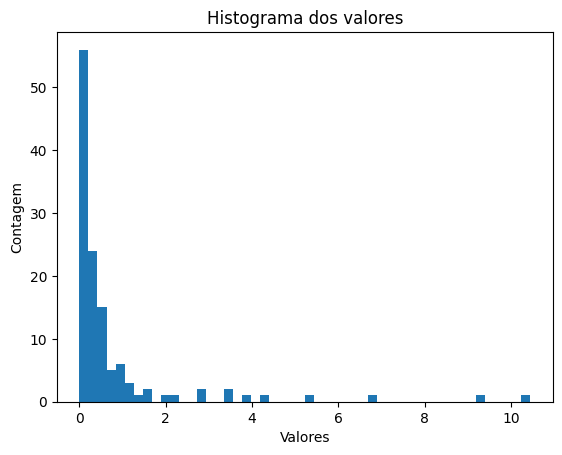

In [280]:
# Criar o histograma
plt.hist(values.numpy(), bins=50)

# Adicionar título e rótulos aos eixos
plt.title("Histograma dos valores")
plt.xlabel("Valores")
plt.ylabel("Contagem")

# Mostrar o histograma
plt.show()

In [ ]:
normalized_values = (wj_sum_sparse._values() - wj_sum_sparse._values().min()) / (wj_sum_sparse._values().max() - wj_sum_sparse._values().min())


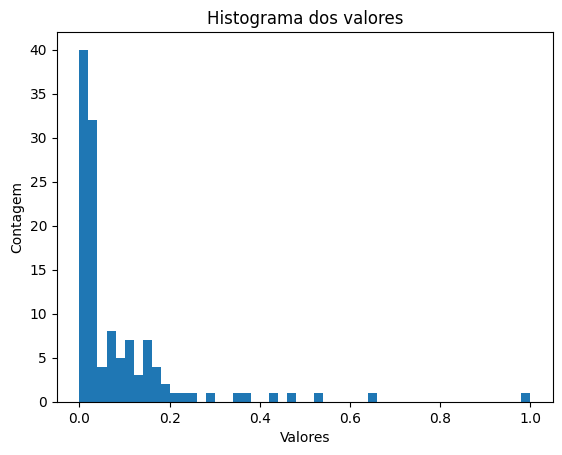

In [281]:
# Criar o histograma
plt.hist(normalized_values.numpy(), bins=50)

# Adicionar título e rótulos aos eixos
plt.title("Histograma dos valores")
plt.xlabel("Valores")
plt.ylabel("Contagem")

# Mostrar o histograma
plt.show()

In [279]:
normalized_values.min(), normalized_values.mean(), normalized_values.median(), normalized_values.max()

(tensor(0.), tensor(8.5426e-02), tensor(3.3906e-02), tensor(1.0000e+00))

In [90]:
wj_sum_sparse._values().shape, wj_sum_sparse._values().sum()

(torch.Size([123]), tensor(9.5482e+01))

## Compreendendo tensor esparso

In [91]:
wj_sum_sparse._indices().shape


torch.Size([2, 123])

In [92]:
print(f"Número de subwords/tokens de entrada: {wj_sum_sparse._indices()[0].max() + 1}")

Número de subwords/tokens de entrada: 2


In [93]:
print(f"Qtd de elementos no vetor esparso: {wj_sum_sparse._nnz()}")

Qtd de elementos no vetor esparso: 123


In [94]:
wj_sum_sparse.element_size(), wj_sum_sparse.sparse_dim(), wj_sum_sparse.numel(), wj_sum_sparse._nnz()

(4, 2, 61044, 123)

### Visualizando economia de espaço

In [95]:
# calcula o tamanho em bytes do tensor esparso
mem_vetor_esparso = wj_sum_sparse.element_size() * wj_sum_sparse._nnz()  

In [96]:
# calcula o tamanho em bytes do tensor contíguo
mem_vetor_contiguo = wj_sum.element_size() * wj_sum.numel()  

In [97]:
print(f"Memória vetor esparso {mem_vetor_esparso} x contíguo {mem_vetor_contiguo} {round(100*mem_vetor_esparso/mem_vetor_contiguo,3)}%")

Memória vetor esparso 492 x contíguo 244176 0.201%


In [98]:
# t = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6]])

unique_vals, counts = torch.unique(wj_sum_sparse._indices()[0], return_counts=True)

In [99]:
counts_dict = {val.item(): count.item() for val, count in zip(unique_vals, counts)}


In [100]:
print(counts_dict)

{0: 70, 1: 53}


In [101]:
values_dict = {}
unique_indices = torch.unique(wj_sum_sparse._indices()[0])
for idx in unique_indices:
    values_dict[idx.item()] = wj_sum_sparse._indices()[1][wj_sum_sparse._indices()[0] == idx].tolist()


In [102]:
print(values_dict)

{0: [1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782], 1: [1999, 2061, 2062, 2074, 2116, 2205, 2261, 2338, 2411, 2466, 2561, 2671, 2726, 2773, 2878, 2904, 3191, 3213, 3365, 3375, 3432, 3674, 3722, 3752, 3793, 3975, 4471, 4489, 4706, 4800, 4807, 5290, 5449, 5530, 6251, 6310, 6412, 6796, 7063, 7065, 7680, 8553, 8590, 8651, 9185, 9491, 10938, 11091, 11746, 12654, 14686, 20423, 21743]}


In [103]:
for pos, list_tokens in values_dict.items():
    print(f"pos {pos}:{sentences_test[pos]}")
    print(f"{list_tokens}")
    print(f"{tokenizer.convert_ids_to_tokens(list_tokens)} ")

# tokenizer.convert_ids_to_tokens(wj_sparse._indices()[1])

pos 0:He likes to eat pizza in the pizza hut.
[1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782]
['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald

## Usando "max"

In [104]:
wj_max, _ = torch.max(torch.log(1 + relu(logits)), dim=1)

In [105]:
wj_max_sparse = wj_max.to_sparse()

In [106]:
wj_max_sparse.shape

torch.Size([2, 30522])

In [107]:
# t = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6]])
unique_vals, counts = torch.unique(wj_max_sparse._indices()[0], return_counts=True)
counts_dict = {val.item(): count.item() for val, count in zip(unique_vals, counts)}
print(counts_dict)

{0: 70, 1: 53}


In [108]:
values_dict = {}
unique_indices = torch.unique(wj_max_sparse._indices()[0])
for idx in unique_indices:
    values_dict[idx.item()] = wj_max_sparse._indices()[1][wj_max_sparse._indices()[0] == idx].tolist()


In [109]:
print(values_dict)

{0: [1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782], 1: [1999, 2061, 2062, 2074, 2116, 2205, 2261, 2338, 2411, 2466, 2561, 2671, 2726, 2773, 2878, 2904, 3191, 3213, 3365, 3375, 3432, 3674, 3722, 3752, 3793, 3975, 4471, 4489, 4706, 4800, 4807, 5290, 5449, 5530, 6251, 6310, 6412, 6796, 7063, 7065, 7680, 8553, 8590, 8651, 9185, 9491, 10938, 11091, 11746, 12654, 14686, 20423, 21743]}


In [110]:
for pos, list_tokens in values_dict.items():
    print(f"pos {pos}:{sentences_test[pos]}")
    print(f"{list_tokens}")
    print(f"{tokenizer.convert_ids_to_tokens(list_tokens)} ")

# tokenizer.convert_ids_to_tokens(wj_sparse._indices()[1])

pos 0:He likes to eat pizza in the pizza hut.
[1996, 1999, 2002, 2006, 2010, 2012, 2032, 2066, 2079, 2123, 2215, 2252, 2283, 2359, 2365, 2370, 2377, 2380, 2567, 2677, 2720, 2767, 2806, 2833, 2839, 3124, 3309, 3347, 3364, 3531, 3573, 3782, 3829, 3899, 3942, 4147, 4435, 4497, 4521, 4605, 4666, 4669, 4713, 4825, 5404, 5440, 5470, 5542, 5965, 5983, 6240, 6805, 6871, 7668, 7777, 7884, 8738, 8808, 9065, 9383, 9544, 9841, 10026, 10733, 11345, 11642, 12570, 15890, 18959, 19782]
['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald

In [111]:
wj_max_sparse._values().sum(), wj_sum_sparse._values().sum()

(tensor(5.4646e+01), tensor(9.5482e+01))

## Conclusão dos experimentos


As expansões se equivalem, seja usando max ou sum, pois as 123 tokens (após expansão) são as 123 não zeradas do logits (após relu).
O que muda são os valores dos scores das tokens, o que pode influenciar na busca (sum:95, max:54)


# Funções auxiliares

## De expansão/inferência

In [138]:
def retorna_subword_importante(
    parm_model: BertForMaskedLM,
    parm_tokenizer: BertTokenizer,
    parm_sentences: list,
    parm_ind_agg: str = 'max',
    parm_se_usa_sep: bool = True
  )  -> torch.sparse.FloatTensor:
    """
    Retorna um tensor esparso contendo as subpalavras importantes de cada sentença fornecida.

    Args:
        parm_model (BertForMaskedLM): O modelo pré-treinado utilizado para geração de embeddings.
        parm_tokenizer (BertTokenizer): O tokenizador associado ao modelo pré-treinado.
        parm_sentences (list): A lista de sentenças para as quais se deseja obter as subpalavras importantes.
        parm_ind_agg (str): O método de agregação de índices para geração do tensor esparso. As opções são:
                                            - 'max': para agregar índices por meio do valor máximo naquela posição;
                                            - 'sum': para agregar índices por meio da soma naquela posição.

    Returns:
        torch.sparse.FloatTensor: O tensor esparso com as subpalavras importantes de cada sentença.
    """
    assert parm_ind_agg in ['max','sum'], f"parm_ind_aggregation_method deve ser 'max' ou 'sum', mas passado {parm_ind_agg}!"

    encoded_input = parm_tokenizer(parm_sentences,
                                    add_special_tokens=True,
                                    return_special_tokens_mask=True, 
                                    padding=True, 
                                    truncation=True,
                                    max_length=model.config.max_position_embeddings,
                                    return_tensors='pt')



    encoded_input = BatchEncoding(encoded_input)
    encoded_input_cuda = {key: value.to(device) for key, value in encoded_input.items()}
    with torch.no_grad():
        model_output = parm_model(**{k:v for k,v in encoded_input_cuda.items() if k != 'special_tokens_mask'})
    logits = model_output.logits    # estava movendo para a cpu aqui!
    assert logits.shape[0]== len(parm_sentences), f"logits.shape[0] deveria ser igual a len(sentences_test), mas {logits.shape[0]} != {len(sentences_test)}"
    assert logits.shape[1] ==  encoded_input['input_ids'].shape[1], f"logits.shape[1] ==  encoded_input['input_ids'].shape[1], mas {logits.shape[1]} != {encoded_input['input_ids'].shape[1]}"
    assert logits.shape[2]== model.config.vocab_size, f"logits.shape[2] deveria ser igual model.config.vocab_size, mas {logits.shape[2]} != {model.config.vocab_size}  "
    # print(f"model_output.logits.shape {model_output.logits.shape}")
    if parm_se_usa_sep:
        if parm_ind_agg == 'max':
            wj, _ = torch.max(torch.log(1 + relu(logits)), dim=1)
        elif parm_ind_agg == 'sum':
            wj = torch.sum(torch.log(1 + relu(logits)), dim=1)
    else:
        if parm_ind_agg == 'max':
            wj, _ = torch.max(torch.log(1 + relu(logits[:,1:-1,:])), dim=1)
        elif parm_ind_agg == 'sum':
            wj = torch.sum(torch.log(1 + relu(logits[:, 1:-1,:])), dim=1)

    return wj.cpu().to_sparse()


In [121]:
def retorna_tokens_expansao_dict(parm_expansao: torch.Tensor, 
                            parm_tokenizer: BertTokenizer,
                            parm_sentences: list) -> dict:
    """
    Retorna um dicionário com informações sobre as expansões de tokens para cada sentença.

    Args:
        parm_expansao (torch.Tensor): Tensor esparso com as expansões de tokens.
        parm_tokenizer (BertTokenizer): Tokenizer associado ao modelo BERT utilizado nas expansões.
        parm_sentences (list): Lista de sentenças utilizadas para gerar as expansões.

    Returns:
        dict: Dicionário com informações sobre as expansões de tokens para cada sentença. Cada item do dicionário
        contém as seguintes chaves:
        - 'text': A sentença original.
        - 'list_tokens_expanded': Uma lista de tokens correspondente às expansões geradas para a sentença.
    """
    # Verifica se o número de linhas da expansão é igual ao número de sentenças
    assert parm_expansao.shape[0] == len(parm_sentences), f"parm_expansao.shape[0] == len(parm_sentences), mas {parm_expansao.shape[0]} != {len(parm_sentences)}"

    # Cria um dicionário para armazenar os valores únicos presentes na expansão
    values_dict = {}
    # Obtém os índices únicos da expansão
    unique_indices = torch.unique(parm_expansao._indices()[0])
    # Para cada índice único, armazena a lista de tokens correspondente
    for idx in unique_indices:
        values_dict[idx.item()] = parm_expansao._indices()[1][parm_expansao._indices()[0] == idx].tolist()

    # Cria um dicionário de retorno com as informações de cada sentença
    dict_retorno = {}
    for pos, list_tokens in values_dict.items():
        dict_retorno[pos] = {'text': parm_sentences[pos], 
                             'list_tokens_expanded': parm_tokenizer.convert_ids_to_tokens(list_tokens)}
    return dict_retorno


In [122]:
def expande_corpus(parm_model:BertForMaskedLM,
                   parm_tokenizer:BertTokenizer, 
                   parm_sentences:list,
                   parm_batch_size:int=64,
                   parm_ind_agg:str='max',
                   parm_se_usa_sep: bool = True) -> torch.Tensor:
    """
    Gera a expansão de palavras para um conjunto de documentos usando um modelo de linguagem BERT pré-treinado.

    Args:
    - parm_model: modelo BERT pré-treinado.
    - parm_tokenizer: tokenizer associado ao modelo BERT.
    - parm_sentences: lista contendo os documentos (em forma de string) a serem expandidos.
    - parm_batch_size: tamanho do batch para processamento em lotes. O padrão é 64.
    - parm_ind_agg: método de agregação de subpalavras. As opções são: 'max' (valor máximo) ou 'sum' (soma).
    O padrão é 'max'.

    Returns:
    - torch.Tensor: matriz esparsa com a representação das subpalavras importantes para cada documento.
    """
    # Comando para reduzir tempo e memória with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
    # Matriz esparsa que irá armazenar as subpalavras importantes para cada documento.
    expansoes = None  
    # Calcula a quantidade de lotes a serem processados.
    qtd_bloco = math.ceil(len(parm_sentences) / parm_batch_size)  
    # Cria uma barra de progresso para acompanhar o processamento.    
    pbar = tqdm(range(qtd_bloco))  
    for ndx in range(qtd_bloco):
        # Seleciona o conjunto de documentos a serem processados no lote atual.
        lista_doctos = [docto['texto_titulo'] for docto in parm_sentences[ndx*parm_batch_size:ndx*parm_batch_size+parm_batch_size]]
        # Chama a função que gera a expansão de subpalavras      
        expansoes_batch = retorna_subword_importante(parm_model=parm_model, parm_tokenizer=parm_tokenizer, parm_sentences=lista_doctos, parm_ind_agg=parm_ind_agg, parm_se_usa_sep=parm_se_usa_sep)
        # Concatena as expansões geradas no lote atual com as expansões já armazenadas na matriz esparsa.
        if expansoes is None:
            expansoes = expansoes_batch
        else:
            expansoes = torch.cat( (expansoes, expansoes_batch), dim=0)
        # if ndx%10==0:
        #    torch.cuda.empty_cache()
        # Atualiza a barra de progresso.
        pbar.update(n=1)
        pbar.refresh()

    # Exibe a mensagem indicando a quantidade de expansões geradas e retorna a matriz esparsa com as subpalavras importantes.
    print(f"Expansões geradas: shape {expansoes.shape}")
    return expansoes


## De busca

In [123]:
def retorna_tensor_unitario_em_tokens(parm_tokenizer:BertTokenizer, parm_texto:str) -> torch.Tensor:
    """
    Função que recebe um tokenizer e um parm_ e retorna um tensor com um único valor 1.0 em cada posição
    correspondente aos tokens do texto.

    :param parm_tokenizer: objeto BertTokenizer, responsável por tokenizar o texto
    :type parm_tokenizer: BertTokenizer
    :param texto: texto a ser tokenizado
    :type texto: str
    :return: tensor com um único valor 1.0 em cada posição correspondente aos tokens do texto
    :rtype: torch.Tensor
    """
    
    assert isinstance(parm_texto, str) or ( isinstance(parm_texto, list) and  isinstance(parm_texto[0], str)   ) , f"parm_texto deve ser str ou lista com uma string"
    # tokeniza o texto e obtém a lista de tokens
    lista_tokens = parm_tokenizer(parm_texto,
                                    add_special_tokens=False,
                                    return_special_tokens_mask=False, 
                                    padding=False, 
                                    truncation=True,
                                    max_length=tokenizer.max_len_single_sentence,
                                    return_tensors='pt')['input_ids']
    

    # cria um tensor vazio com o tamanho do vocabulário
    tensor = torch.zeros(parm_tokenizer.vocab_size, dtype=torch.float32)

    # define os valores 1.0 nas posições correspondentes aos índices dos tokens na lista
    tensor[lista_tokens] = 1.0

    return tensor.squeeze()


In [341]:
def run_all_queries_busca_exaustiva(parm_model:BertForMaskedLM,
                                    parm_tokenizer:BertTokenizer, 
                                    parm_dict_queries:{},
                                    parm_corpus_expanded, 
                                    parm_lista_doc_id_passage:list,
                                    parm_num_max_hits:int=1000,
                                    parm_se_query_expansion:bool=False,
                                    parm_ind_agg_se_query_expansion:str=None,
                                    parm_se_usa_sep_query_expansion: bool = True):
    assert parm_ind_agg_se_query_expansion and parm_se_query_expansion or not parm_se_query_expansion, \
        f"se parm_se_query_expansion {parm_se_query_expansion} for True, deve-se informar parm_ind_agg_se_query_expansion {parm_ind_agg_se_query_expansion}"
    tempos = []
    with open(CAMINHO_RUN, 'w') as runfile:
        for cnt, (query_id, value) in enumerate(parm_dict_queries.items()):
            # print(id, value)
            tempo_inicio = time.time()
            if parm_se_query_expansion:
                query_scores = retorna_subword_importante(parm_model=parm_model,
                                                parm_tokenizer=parm_tokenizer,
                                                parm_sentences=[value['question']], 
                                                parm_ind_agg=parm_ind_agg_se_query_expansion, parm_se_usa_sep=parm_se_usa_sep_query_expansion).to_dense().squeeze().to(device)
            else:
                query_scores = retorna_tensor_unitario_em_tokens(parm_tokenizer, value['question']).to(device)

            # Pega os primeiros 1000 resultados
            score = torch.matmul(parm_corpus_expanded, query_scores)
            # Ordena
            sorted_score, indices_score = torch.sort(score, descending=True)

            # parm_num_max_hits primeiros
            sorted_score = sorted_score[0:parm_num_max_hits]
            indices_score = indices_score[0:parm_num_max_hits]

            if cnt % 5 == 0:
                print(f'{cnt} queries completadas')

            # ids dos documentos
            ids_docs = [parm_lista_doc_id_passage[i] for i in indices_score]

            tempos.append(time.time() - tempo_inicio)

            #  query  q0     docid  rank     score    descr    
            for i, (id_doc, score) in enumerate(zip(ids_docs, sorted_score)):
                texto_docto = f'{query_id} Q0 {id_doc} {i+1} {float(score):.6f} Pesquisa\n'
                _ = runfile.write(texto_docto)
    return tempos
                

## Validando função a partir dos experimentos

In [143]:
expansao = retorna_subword_importante(model, tokenizer, sentences_test,'max')

In [144]:
expansao._values().shape, wj_max_sparse._values().shape

(torch.Size([123]), torch.Size([123]))

In [145]:
expansao._values()

tensor([3.3765e-01, 6.8221e-01, 1.5982e+00, 5.0857e-02, 9.4812e-01, 3.5866e-01,
        4.8299e-01, 1.1775e+00, 2.9630e-01, 1.3672e-01, 7.5528e-01, 4.6717e-01,
        1.1937e-01, 2.1403e-01, 2.0454e-01, 2.5286e-01, 4.5247e-02, 1.0496e-01,
        1.0644e-01, 1.6179e-01, 4.3446e-02, 1.0081e-01, 4.1281e-01, 4.8925e-01,
        5.7536e-01, 1.9165e-01, 4.2052e-01, 3.6059e-01, 3.3028e-01, 4.5783e-02,
        7.9688e-02, 8.9580e-02, 7.0697e-02, 3.7899e-03, 5.3535e-01, 2.8417e-01,
        2.6173e-02, 4.0734e-01, 1.5950e+00, 2.7536e-01, 6.8446e-02, 1.3489e+00,
        1.5299e-02, 1.1615e+00, 1.5816e-01, 3.1976e-01, 2.1513e-01, 3.0995e-03,
        1.0105e-02, 8.8060e-01, 2.0546e-01, 7.6037e-02, 5.6824e-01, 1.0535e-01,
        1.2577e+00, 2.2530e-01, 1.8002e-01, 3.2390e-02, 1.0712e-01, 9.5720e-05,
        5.7925e-01, 5.3655e-02, 1.7398e-01, 2.3948e+00, 1.0933e+00, 3.1051e-01,
        2.0591e+00, 4.5885e-01, 6.9909e-02, 1.0345e-01, 6.5284e-02, 7.1823e-01,
        6.4278e-02, 1.3465e+00, 1.4859e+

In [146]:
wj_max_sparse._values()

tensor([3.3765e-01, 6.8221e-01, 1.5982e+00, 5.0857e-02, 9.4812e-01, 3.5866e-01,
        4.8299e-01, 1.1775e+00, 2.9630e-01, 1.3672e-01, 7.5528e-01, 4.6717e-01,
        1.1937e-01, 2.1403e-01, 2.0454e-01, 2.5286e-01, 4.5247e-02, 1.0496e-01,
        1.0644e-01, 1.6179e-01, 4.3446e-02, 1.0081e-01, 4.1281e-01, 4.8925e-01,
        5.7536e-01, 1.9165e-01, 4.2052e-01, 3.6059e-01, 3.3028e-01, 4.5783e-02,
        7.9688e-02, 8.9580e-02, 7.0697e-02, 3.7899e-03, 5.3535e-01, 2.8417e-01,
        2.6173e-02, 4.0734e-01, 1.5950e+00, 2.7536e-01, 6.8446e-02, 1.3489e+00,
        1.5299e-02, 1.1615e+00, 1.5816e-01, 3.1976e-01, 2.1513e-01, 3.0995e-03,
        1.0105e-02, 8.8060e-01, 2.0546e-01, 7.6037e-02, 5.6824e-01, 1.0535e-01,
        1.2577e+00, 2.2530e-01, 1.8002e-01, 3.2390e-02, 1.0712e-01, 9.5720e-05,
        5.7925e-01, 5.3655e-02, 1.7398e-01, 2.3948e+00, 1.0933e+00, 3.1051e-01,
        2.0591e+00, 4.5885e-01, 6.9909e-02, 1.0345e-01, 6.5284e-02, 7.1823e-01,
        6.4278e-02, 1.3465e+00, 1.4859e+

In [147]:
torch.allclose(wj_max_sparse._values(), expansao._values(), 1e-3)

True

In [148]:
dict_retorno = retorna_tokens_expansao_dict(expansao, tokenizer,sentences_test)
print(dict_retorno)


{0: {'text': 'He likes to eat pizza in the pizza hut.', 'list_tokens_expanded': ['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald', 'prefer', 'dish', 'chef', 'pizza', 'pie', 'sandwich', 'hut', 'burger', 'dislike', 'snack']}, 1: {'text': 'So many sentences are transformed in just a summary.', 'list_tokens_expanded': ['in', 'so', 'more', 'just', 'many', 'too', 'few', 'book', 'often', 'story', 'total', 'science', 'thomas', 'word', 'whole', 'changed', 'read', 'writer', 'numerous', 'complex', 'simply', 'multiple', 'simple',

In [152]:
dict_ret_zero = dict_retorno[0]['list_tokens_expanded']
print(dict_ret_zero)

['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'store', 'chris', 'kitchen', 'dog', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'cafe', 'likes', 'restaurants', 'diet', 'cheese', 'booth', 'mcdonald', 'prefer', 'dish', 'chef', 'pizza', 'pie', 'sandwich', 'hut', 'burger', 'dislike', 'snack']


In [130]:
expansao = retorna_subword_importante(model, tokenizer, sentences_test,'sum')

In [131]:
expansao._values().shape, wj_sum_sparse._values().shape

(torch.Size([123]), torch.Size([123]))

In [132]:
torch.allclose(wj_sum_sparse._values(), expansao._values(), 1e-3)

True

Sem considerar special toknes

In [154]:
expansao = retorna_subword_importante(model, tokenizer, sentences_test,'max',parm_se_usa_sep=False)

In [155]:
expansao._values().shape, wj_max_sparse._values().shape

(torch.Size([111]), torch.Size([123]))

In [156]:
expansao._values()

tensor([3.3765e-01, 6.8221e-01, 1.5982e+00, 5.0857e-02, 9.4812e-01, 3.5866e-01, 4.3332e-01, 1.1775e+00, 2.9630e-01,
        1.3672e-01, 7.5528e-01, 4.6717e-01, 1.1937e-01, 2.1403e-01, 2.0454e-01, 2.5286e-01, 4.5247e-02, 1.0496e-01,
        1.0644e-01, 1.6179e-01, 4.3446e-02, 1.0081e-01, 4.1281e-01, 4.8925e-01, 5.7536e-01, 1.5575e-01, 4.2052e-01,
        3.6059e-01, 3.3028e-01, 4.5783e-02, 8.9580e-02, 5.3535e-01, 2.8417e-01, 2.6173e-02, 4.0734e-01, 1.5950e+00,
        2.7536e-01, 6.8446e-02, 1.3489e+00, 1.5299e-02, 1.1615e+00, 1.5816e-01, 3.1976e-01, 2.1513e-01, 3.0995e-03,
        1.0105e-02, 8.8060e-01, 2.0546e-01, 7.6037e-02, 5.6824e-01, 1.2577e+00, 1.2225e-01, 1.8002e-01, 9.3994e-02,
        5.7925e-01, 3.8376e-02, 2.3948e+00, 1.0933e+00, 1.9203e-01, 2.0591e+00, 3.1836e-01, 6.9909e-02, 1.0345e-01,
        6.5284e-02, 7.1823e-01, 6.4278e-02, 1.3465e+00, 1.4859e+00, 2.3125e-02, 1.1274e-01, 1.0177e-01, 1.8514e-01,
        3.5824e-01, 2.0234e-01, 1.6038e-01, 1.7059e-01, 1.9380e-01, 6.60

In [157]:
dict_retorno = retorna_tokens_expansao_dict(expansao, tokenizer,sentences_test)
print(dict_retorno)


{0: {'text': 'He likes to eat pizza in the pizza hut.', 'list_tokens_expanded': ['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'chris', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'likes', 'restaurants', 'diet', 'booth', 'prefer', 'dish', 'pizza', 'pie', 'sandwich', 'hut', 'burger', 'dislike', 'snack']}, 1: {'text': 'So many sentences are transformed in just a summary.', 'list_tokens_expanded': ['in', 'so', 'more', 'just', 'many', 'too', 'few', 'book', 'often', 'story', 'total', 'word', 'whole', 'changed', 'read', 'writer', 'numerous', 'complex', 'simply', 'multiple', 'simple', 'reading', 'text', 'split', 'message', 'difference', 'literary', 'multi', 'reform', '

In [158]:
dict_ret_zero2 = dict_retorno[0]['list_tokens_expanded']
print(dict_ret_zero2)

['the', 'in', 'he', 'on', 'his', 'at', 'him', 'like', 'do', 'don', 'want', 'club', 'party', 'wanted', 'son', 'himself', 'play', 'park', 'brother', 'mouth', 'mr', 'friend', 'style', 'food', 'character', 'guy', 'hotel', 'bar', 'actor', 'please', 'chris', 'visit', 'wearing', 'brand', 'shop', 'eat', 'bowl', 'mix', 'liked', 'factory', 'restaurant', 'beer', 'favorite', 'fan', 'cousin', 'fred', 'eating', 'meat', 'bite', 'preferred', 'likes', 'restaurants', 'diet', 'booth', 'prefer', 'dish', 'pizza', 'pie', 'sandwich', 'hut', 'burger', 'dislike', 'snack']


Algumas tokens não vieram!

In [160]:
[x for x in dict_ret_zero if x not in dict_ret_zero2]

['store', 'kitchen', 'dog', 'cafe', 'cheese', 'mcdonald', 'chef']

# Expandindo documentos

#### Um subconjunto para testar

In [165]:
%%time
corpus_expanded = expande_corpus(parm_model=model,
                   parm_tokenizer=tokenizer, 
                   parm_sentences=corpus[:512],
                   parm_batch_size=64,
                   parm_ind_agg='max', parm_se_usa_sep=False )

100%|██████████| 8/8 [00:00<00:00, 28.63it/s]

Expansões geradas: shape torch.Size([512, 30522])
CPU times: user 2.24 s, sys: 41.3 ms, total: 2.28 s
Wall time: 281 ms


In [166]:
len(corpus_expanded)

512

In [167]:
lista_doctos = [docto['texto_titulo'] for docto in corpus[:512]]

Sem considerar logitos nas posições limites 

In [168]:
dict_retorno = retorna_tokens_expansao_dict(corpus_expanded,
                                       tokenizer, 
                                       lista_doctos)
print(dict_retorno[0])

{'text': 'ABSTRACTS. ', 'list_tokens_expanded': ['"', '.', ':', ';', 'this', 'what', 'hand', 'science', 'thomas', 'word', 'study', 'richard', 'smith', 'collection', 'theory', 'alexander', 'alex', 'stephen', 'davis', 'philosophy', 'category', 'literary', 'ian', 'gordon', 'morgan', 'classification', 'marshall', 'austin', 'roy', 'definition', 'document', 'terry', 'greg', 'justin', 'craig', 'madison', 'owen', 'biology', 'assessment', 'holland', 'declaration', 'qualification', 'bailey', 'burke', 'raven', 'abstract', 'sherman', 'clause', 'citation', 'bart', 'marty', 'barrett', 'pearson', 'forensic', 'brenda', 'fuzzy', 'abbreviation', 'abstracts']}


Considerando os logitos nas posições limites 

In [164]:
dict_retorno = retorna_tokens_expansao_dict(corpus_expanded,
                                       tokenizer, 
                                       lista_doctos)
print(dict_retorno[0])

{'text': 'ABSTRACTS. ', 'list_tokens_expanded': ['"', '.', ':', ';', 'an', 'this', 'what', 'hand', 'order', 'science', 'thomas', 'word', 'study', 'dr', 'richard', 'medical', 'smith', 'collection', 'theory', 'legal', 'alexander', 'steve', 'alex', 'andrew', 'harry', 'brian', 'stephen', 'davis', 'philosophy', 'category', 'literary', 'ian', 'albert', 'gene', 'gordon', 'clark', 'morgan', 'carl', 'classification', 'ross', 'marshall', 'austin', 'fred', 'roy', 'gabriel', 'definition', 'document', 'helen', 'morris', 'description', 'terry', 'greg', 'justin', 'craig', 'madison', 'spencer', 'owen', 'reed', 'biology', 'assessment', 'regulation', 'holland', 'declaration', 'qualification', 'ellis', 'blank', 'bailey', 'edgar', 'alec', 'burke', 'raven', 'abstract', 'beck', 'sherman', 'clause', 'citation', 'dana', 'joyce', 'bart', 'avery', 'marty', 'barrett', 'pearson', 'gil', 'forensic', 'brenda', 'fuzzy', 'abbreviation', 'duane', 'abstracts']}


 ### Expandindo todo o corpus  "naver/splade-cocondenser-ensembledistil"

Tempo para inferência/espansão:

        Usando gpu para sum/max nos logitos
        (e ordenando por tamanho de texto e batch_size 64)
                sum: 25min




#### MAX, usando sep

In [170]:
# Limpa o cache da memória da GPU
torch.cuda.empty_cache()

In [171]:
%%time
corpus_expanded = expande_corpus(parm_model=model,
                   parm_tokenizer=tokenizer, 
                   parm_sentences=corpus,
                   parm_batch_size=64,
                   parm_ind_agg='max', parm_se_usa_sep=True ) 

100%|██████████| 2675/2675 [24:30<00:00,  1.82it/s]

Expansões geradas: shape torch.Size([171184, 30522])
CPU times: user 1h 29min 22s, sys: 5min 28s, total: 1h 34min 50s
Wall time: 24min 30s


In [229]:
tempo_construcao_indice_splade = 24 * 60 + 30
print(f"Tempo para construir o índice: {tempo_construcao_indice_splade}")

Tempo para construir o índice: 1470


In [172]:
with open(CAMINHO_ARQUIVO_EXPANSAO_MAX, 'wb') as outputFile:
    pickle.dump(corpus_expanded, outputFile, pickle.HIGHEST_PROTOCOL)

In [174]:
len(corpus_expanded)

171184

In [175]:
corpus_expanded.shape

torch.Size([171184, 30522])

#### MAX, sem usar sep

In [176]:
# Limpa o cache da memória da GPU
torch.cuda.empty_cache()

In [177]:
%%time
corpus_expanded_sem_sep = expande_corpus(parm_model=model,
                   parm_tokenizer=tokenizer, 
                   parm_sentences=corpus,
                   parm_batch_size=64,
                   parm_ind_agg='max', parm_se_usa_sep=False ) 

100%|██████████| 2675/2675 [24:16<00:00,  1.84it/s]

Expansões geradas: shape torch.Size([171184, 30522])
CPU times: user 1h 28min 57s, sys: 5min 11s, total: 1h 34min 8s
Wall time: 24min 16s


In [228]:
tempo_construcao_indice_splade_sem_sep = 24 * 60 + 16
print(f"Tempo para construir o índice: {tempo_construcao_indice_splade_sem_sep}")

Tempo para construir o índice: 1456


In [178]:
with open(CAMINHO_ARQUIVO_EXPANSAO_MAX_SEM_SEP, 'wb') as outputFile:
    pickle.dump(corpus_expanded_sem_sep, outputFile, pickle.HIGHEST_PROTOCOL)

In [179]:
len(corpus_expanded_sem_sep)

171184

In [180]:
corpus_expanded_sem_sep.shape

torch.Size([171184, 30522])

#### Comparando memória corpus esparso x contíguo 

In [185]:
corpus_expanded_exparse = corpus_expanded.to_sparse()

In [186]:
# calcula o tamanho em bytes do tensor esparso
mem_vetor_esparso = corpus_expanded_exparse.element_size() * \
                        corpus_expanded_exparse._nnz()  

In [187]:
# calcula o tamanho em bytes do tensor contíguo
mem_vetor_contiguo = corpus_expanded.element_size() * \
    corpus_expanded.numel()  # calcula o tamanho em bytes do tensor esparso

In [188]:
print(f"Memória vetor esparso {mem_vetor_esparso} x contíguo {mem_vetor_contiguo} {round(100*mem_vetor_esparso/mem_vetor_contiguo,3)}%")

Memória vetor esparso 123765204 x contíguo 20899512192 0.592%


In [340]:
corpus_expanded_exparse = corpus_expanded_exparse.to(device)

Economia: 122 mb x 20 gb (0,587%)

In [203]:
tamanho_em_bytes_indice_splade = mem_vetor_esparso

In [204]:
print(f"Memória ocupada pelo índice: {tamanho_em_bytes_indice_splade}")

Memória ocupada pelo índice: 123765204


In [339]:
corpus_expanded_exparse_sem_sep = corpus_expanded_sem_sep.to_sparse().to(device)

In [226]:
# calcula o tamanho em bytes do tensor esparso
tamanho_em_bytes_indice_splade_sem_sep = corpus_expanded_exparse_sem_sep.element_size() * \
                        corpus_expanded_exparse_sem_sep._nnz()  

In [227]:
print(f"Memória ocupada pelo índice sem sep: {tamanho_em_bytes_indice_splade_sem_sep}")

Memória ocupada pelo índice sem sep: 121051960


# Funções de apoio - gastos computacionais

In [195]:
def retorna_calculo_contexto (parm_resultado_pipeline: dict,
                      parm_tipo_gpu:str='3090',
                      ):
    """
      Método para efetuar cálculos de gastos conforme
        parm_tipo_gpu
        parm_resultado_pipeline
     
    """ 
    global lista_pipeline 
    assert parm_tipo_gpu in ['3090'], f"parm_tipo_gpu {parm_tipo_gpu} não está previsto para cálculos!"

    resultado = {}
    for contexto in ['utilizacao_perfeita', 'utilizacao_precaria_100']:
        avaliacao_contexto = calcula_gastos(parm_resultado_pipeline, parm_tipo_gpu, contexto)
        resultado[contexto]= avaliacao_contexto
    return resultado
    




In [196]:
def calcula_gastos (parm_dados: dict,
                      parm_tipo_gpu:str='3090',
                      parm_contexto:str='utilizacao_perfeita'):
    """
        parm_dados deve ter:
                        {'tempo_indexacao_segundo':, lista de tuplas, conforme abaixo:
                                        [{'tipo':'gpu'/'cpu', 'valor': float, segundos}], 
                         'memoria_indice_byte_ram';, 
                         'retrieval_tempo_medio_por_query':,
                         'se_retrieval_usa_gpu':}

    """
    global custo_gpu_segundo, CUSTO_RAM_CPU_HORA_BYTE, CUSTO_CPU_ALOCADA_HORA, CUSTO_CPU_ALOCADA_SEGUNDO
    lista_chave_esperada = ['tempo_indexacao_segundo','memoria_indice_byte_ram','retrieval_tempo_medio_por_query','se_retrieval_usa_gpu']
    assert parm_tipo_gpu in ['3090'], f"parm_tipo_gpu {parm_tipo_gpu} não está previsto para cálculos!"
    assert parm_contexto in ['utilizacao_perfeita', 'utilizacao_precaria_100'], f"parm_contexto {parm_contexto} não está previsto para cálculos!"
    
    for chave in lista_chave_esperada:
        assert chave in parm_dados, f"chave {chave} não está em parm_dados {parm_dados} para os cálculos!"

    dict_retorno = {}


    # custo indexacao
    custo_indexacao_tempo = 0

    ## acumular custo por tempo
    for tempo_valor in parm_dados['tempo_indexacao_segundo']:
        if tempo_valor['tipo'] == 'cpu':
            custo_indexacao_tempo +=  tempo_valor['valor'] * CUSTO_CPU_ALOCADA_SEGUNDO 
        elif tempo_valor['tipo'] == 'gpu':
            custo_indexacao_tempo +=  tempo_valor['valor'] * CUSTO_CPU_ALOCADA_SEGUNDO
        else:
            raise Exception(f"Tipo de tempo deveria ser cpu ou gpu e não {tempo_valor['tipo']}")


    # tem que deixar cpu disponível 24h
    custo_cpu_dia = 24 * CUSTO_CPU_ALOCADA_HORA

    # índice tem que ficar em memória
    custo_memoria_dia = 24 * parm_dados['memoria_indice_byte_ram'] * CUSTO_RAM_CPU_HORA_BYTE

    custo_dia = custo_memoria_dia + custo_cpu_dia

    custo_gpu_dia = 0

    if parm_contexto == 'utilizacao_perfeita': #(assim que terminou de processar uma query, já tem outra para ser processada)

        if parm_dados['se_retrieval_usa_gpu']:
            custo_gpu_dia = 24 * 3600 * custo_gpu_segundo[parm_tipo_gpu]
            custo_dia += custo_gpu_dia 
            print(f"para {parm_contexto} custo gpu dia: {custo_gpu_dia}")

        num_queries_dia = (24 * 3600) / parm_dados['retrieval_tempo_medio_por_query']
        custo_query = round(custo_dia / num_queries_dia, 10)

    elif parm_contexto == 'utilizacao_precaria_100': #(assim que terminou de processar uma query, já tem outra para ser processada)

        if parm_dados['se_retrieval_usa_gpu']:
            custo_gpu_dia = 100 * parm_dados['retrieval_tempo_medio_por_query'] * custo_gpu_segundo[parm_tipo_gpu]
            custo_dia += custo_gpu_dia 
            print(f"para {parm_contexto} custo gpu dia: {custo_gpu_dia}")

        num_queries_dia = 100
        custo_query = round(custo_dia / num_queries_dia, 10)

    return {'usd_query': custo_query, 
            'usd_dia': custo_dia,
            'usd_gpu_dia': custo_gpu_dia,
            'usd_mes': (30 * custo_dia),
            'usd_indexacao_tempo': custo_indexacao_tempo, 
             }


Constantes de valores

In [218]:
custo_gpu_segundo = {'3090': 6.944e-5}

In [219]:
CUSTO_RAM_CPU_HORA_BYTE = 4.656e-12

In [220]:
CUSTO_CPU_ALOCADA_HORA = 0.03



In [221]:
print(CUSTO_CPU_ALOCADA_HORA / 3600)

8.333333333333334e-06


In [222]:
CUSTO_CPU_ALOCADA_SEGUNDO = 8.333e-6


In [331]:
resultado_pipeline = {}
avaliacao_pipeline_contexto = {}

# Realizando as buscas 

## Model  "naver/splade-cocondenser-ensembledistil", Ind_agg = max, Expandindo queries

In [ ]:
nome_modelo = "naver/splade-cocondenser-ensembledistil"

In [332]:
ind_agg = 'max'

In [334]:
se_expande_query = 'S'

### Se usa sep = True

In [335]:
nome_pipeline = 'splade_cocondenser_max_com_sep'

In [336]:
resultado_execucao = {}

In [337]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'gpu', 'valor': tempo_construcao_indice_splade}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_splade
resultado_execucao['se_retrieval_usa_gpu'] = True

Lendo os dados salvos

In [ ]:
with open(CAMINHO_ARQUIVO_EXPANSAO_MAX, "rb") as f:
  corpus_expanded = pickle.load(f)

In [342]:
%%time
tempo_gasto = run_all_queries_busca_exaustiva(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded_exparse, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=1000,
                                    parm_se_query_expansion= (se_expande_query == 'S'),
                                    parm_ind_agg_se_query_expansion='max', parm_se_usa_sep_query_expansion=True)

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 36.2 s, sys: 607 ms, total: 36.8 s
Wall time: 5.75 s


In [343]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.1045239
std       0.3108436
min       0.0585434
25%       0.0605044
50%       0.0607921
75%       0.0609987
max       2.2585480
Name: tempo_gasto, Length: 8, dtype: float64

In [344]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

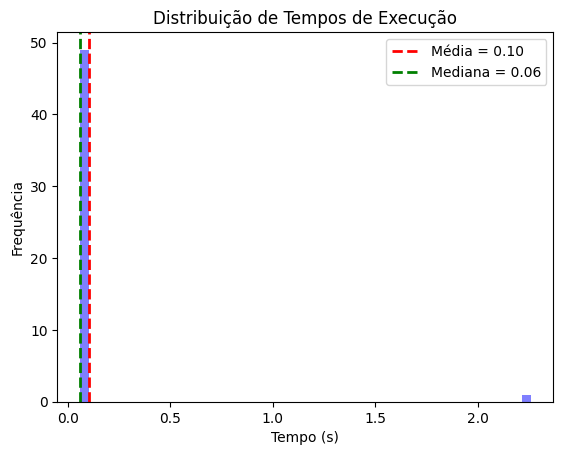

In [345]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação

In [346]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")
results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


   query  q0     docid  rank      score    system
0     44  Q0  dt2pew66     1  24.207752  Pesquisa
1     44  Q0  xfjexm5b     2  23.524042  Pesquisa
2     44  Q0  q0ey3wib     3  23.464104  Pesquisa
3     44  Q0  uc37poce     4  23.422676  Pesquisa
4     44  Q0  qi1henyy     5  23.149395  Pesquisa

[5 rows x 6 columns]
NDCG@10: 0.7214041131725701
Resultados: {'runid': 'Pesquisa', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 11291, 'num_q': 50, 'map': 0.24413788426984034, 'gm_map': 0.19642257827112053, 'bpref': 0.4029954444276047, 'Rprec': 0.3393711698806063, 'recip_rank': 0.9116666666666666, 'P@5': 0.82, 'P@10': 0.7839999999999999, 'P@15': 0.7613333333333334, 'P@20': 0.747, 'P@30': 0.708, 'P@100': 0.5700000000000001, 'P@200': 0.47839999999999994, 'P@500': 0.33052, 'P@1000': 0.22581999999999997, 'NDCG@5': 0.7543679557545698, 'NDCG@10': 0.7214041131725701, 'NDCG@15': 0.7025169944289865, 'NDCG@20': 0.6920838492489894, 'NDCG@30': 0.664219804007807, 'NDCG@100': 0.547241315970716, 'ND

In [347]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [348]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(f"resultado_pipeline[{nome_pipeline}] {resultado_pipeline[nome_pipeline]}")

resultado_pipeline[splade_cocondenser_max_com_sep] {'tempo_indexacao_segundo': [{'tipo': 'gpu', 'valor': 1470}], 'memoria_indice_byte_ram': 123765204, 'se_retrieval_usa_gpu': True, 'retrieval_tempo_medio_por_query': 0.104524, 'ndcg_10': 72.14}


In [349]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

para utilizacao_perfeita custo gpu dia: 5.999616
para utilizacao_precaria_100 custo gpu dia: 0.0007258146560000001
{'utilizacao_perfeita': {'usd_query': 8.1459e-06, 'usd_dia': 6.733446018955775, 'usd_gpu_dia': 5.999616, 'usd_mes': 202.00338056867326, 'usd_indexacao_tempo': 0.01224951}, 'utilizacao_precaria_100': {'usd_query': 0.0073455583, 'usd_dia': 0.7345558336117759, 'usd_gpu_dia': 0.0007258146560000001, 'usd_mes': 22.036675008353278, 'usd_indexacao_tempo': 0.01224951}}


### Se usa sep = False

In [350]:
nome_pipeline = 'splade_cocondenser_max_sem_sep'

In [351]:
resultado_execucao = {}

In [352]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'gpu', 'valor': tempo_construcao_indice_splade_sem_sep}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_splade_sem_sep
resultado_execucao['se_retrieval_usa_gpu'] = True

Lendo os dados salvos

In [353]:
%%time
tempo_gasto = run_all_queries_busca_exaustiva(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded_exparse_sem_sep, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=1000,
                                    parm_se_query_expansion= (se_expande_query == 'S'),
                                    parm_ind_agg_se_query_expansion='max', parm_se_usa_sep_query_expansion=False)

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 33.5 s, sys: 408 ms, total: 33.9 s
Wall time: 3.42 s


In [354]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0587976
std       0.0027432
min       0.0576148
25%       0.0579582
50%       0.0582248
75%       0.0587448
max       0.0772285
Name: tempo_gasto, Length: 8, dtype: float64

In [355]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

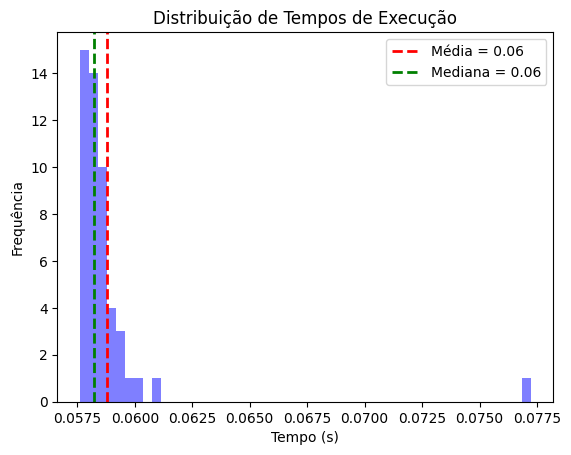

In [356]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação

In [357]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")
results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


   query  q0     docid  rank      score    system
0     44  Q0  dt2pew66     1  24.048674  Pesquisa
1     44  Q0  xfjexm5b     2  23.214937  Pesquisa
2     44  Q0  uc37poce     3  23.209030  Pesquisa
3     44  Q0  q0ey3wib     4  23.062193  Pesquisa
4     44  Q0  qi1henyy     5  22.952564  Pesquisa

[5 rows x 6 columns]
NDCG@10: 0.7199521526159701
Resultados: {'runid': 'Pesquisa', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 11277, 'num_q': 50, 'map': 0.24304992277486878, 'gm_map': 0.1954777095135852, 'bpref': 0.40212941998182816, 'Rprec': 0.3383449848938469, 'recip_rank': 0.9016666666666666, 'P@5': 0.82, 'P@10': 0.7859999999999999, 'P@15': 0.7626666666666666, 'P@20': 0.7429999999999999, 'P@30': 0.7053333333333334, 'P@100': 0.5706000000000001, 'P@200': 0.47729999999999995, 'P@500': 0.32988, 'P@1000': 0.22554000000000002, 'NDCG@5': 0.7531162163491788, 'NDCG@10': 0.7199521526159701, 'NDCG@15': 0.7018007373191492, 'NDCG@20': 0.6896043203797849, 'NDCG@30': 0.6613650956653551, 'NDCG@1

In [358]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [359]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(f"resultado_pipeline[{nome_pipeline}] {resultado_pipeline[nome_pipeline]}")

resultado_pipeline[splade_cocondenser_max_sem_sep] {'tempo_indexacao_segundo': [{'tipo': 'gpu', 'valor': 1456}], 'memoria_indice_byte_ram': 121051960, 'se_retrieval_usa_gpu': True, 'retrieval_tempo_medio_por_query': 0.058798, 'ndcg_10': 72.0}


In [360]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

para utilizacao_perfeita custo gpu dia: 5.999616
para utilizacao_precaria_100 custo gpu dia: 0.000408293312
{'utilizacao_perfeita': {'usd_query': 4.5821e-06, 'usd_dia': 6.73314283021824, 'usd_gpu_dia': 5.999616, 'usd_mes': 201.9942849065472, 'usd_indexacao_tempo': 0.012132848}, 'utilizacao_precaria_100': {'usd_query': 0.0073393512, 'usd_dia': 0.7339351235302399, 'usd_gpu_dia': 0.000408293312, 'usd_mes': 22.0180537059072, 'usd_indexacao_tempo': 0.012132848}}


# Usando indexação lucene 

## Funções auxiliares

In [109]:
def run_all_queries_lucene_splade(file, 
                           topics,
                           searcher,
                           parm_tokenizer, 
                           parm_se_query_expansion:bool=False,
                           parm_ind_agg_se_query_expansion:str=None,
                           parm_num_max_hits:int=1000):
  """
  A função run_all_queries é responsável por realizar todas as consultas armazenadas no dicionário topics utilizando o objeto searcher fornecido e salvar os resultados em um arquivo de texto.
  Usada no notebook da aula 2

  Parâmetros:

  file: caminho do arquivo de saída onde serão salvos os resultados das consultas.
  topics: dicionário contendo as consultas a serem executadas. Cada consulta é representada por uma chave única no dicionário. O valor correspondente a cada chave é um outro dicionário contendo as informações da consulta, como seu título e outras informações relevantes.
  searcher: objeto do tipo Searcher que será utilizado para realizar as consultas.
  num_max_hits: número máximo de documentos relevantes que serão retornados para cada consulta.
  Retorno:

  A função não retorna nenhum valor, mas salva os resultados das consultas no arquivo especificado em file.
  Comentário:

  A função usa a biblioteca tqdm para exibir uma barra de progresso enquanto executa as consultas.
  O número de consultas concluídas é impresso a cada 100 consultas.
  """
  assert parm_ind_agg_se_query_expansion and parm_se_query_expansion or not parm_se_query_expansion, \
        f"se parm_se_query_expansion {parm_se_query_expansion} for True, deve-se informar parm_ind_agg_se_query_expansion {parm_ind_agg_se_query_expansion}"

  print(f'Running {len(topics)} queries in total')

  tempos = []
  

  with open(file, 'w') as runfile:
    cnt = 0
    # for id in tqdm(topics, desc='Running Queries'):
    for id in topics:
        # print(f'id = {id}')
        query = topics[id]['question']
        # print(f'query = {query}')

            

        if parm_se_query_expansion:
            raise Exception('Não implementada busca lucene com expansão de query')
            query_tokens_str = retorna_tokens_expanded_query(parm_model=parm_model,
                                            parm_tokenizer=parm_tokenizer,
                                            parm_sentences=[query], 
                                            parm_ind_agg=parm_ind_agg_se_query_expansion)
        else:
            query_tokens_str = ' '.join(parm_tokenizer.tokenize(query))

        assert isinstance(query_tokens_str,str), f"Assert com erro isinstance(query_tokens_str,'str'), pois é {type(query_tokens_str)}"
        # print(f"query_tokens_str {query_tokens_str}")

        tempo_inicio = time.time()
        hits = searcher.search(query_tokens_str, parm_num_max_hits)
        tempos.append(time.time() - tempo_inicio)

        for i in range(0, len(hits)):
            _ = runfile.write(f'{id} Q0 {hits[i].docid} {i+1} {hits[i].score:.6f} ComExpansao\n')
            # = runfile.write('{} Q0 {} {} {:.6f} Pyserini\n'.format(id, hits[i].docid, i+1, hits[i].score))
        cnt += 1
        if cnt % 100 == 0:
            print(f'{cnt} queries completed')
  return tempos


In [110]:
' dfsd ' * 2

' dfsd  dfsd '

In [155]:
def retorna_tokens_texto_e_expansao_jsonl(parm_expansao: torch.Tensor, 
                            parm_tokenizer: BertTokenizer,
                            parm_lista_doc_id_passage: list,
                            valor_uma_ocorrencia:float=None,
                            ) -> dict:
    """
    Retorna um dicionário com informações sobre as expansões de tokens para cada sentença.

    Args:
        parm_expansao (torch.Tensor): Tensor esparso com as expansões de tokens.
        parm_tokenizer (BertTokenizer): Tokenizer associado ao modelo BERT utilizado nas expansões.
        parm_lista_doc_id_passage: lista de id de docs correspondendo ao tensor em parm_expansao
    Returns:
    {"id": "kvhoa2se", "contents": "tokens dos tensores em parm_expansao"}
    """
    # Verifica se o número de linhas da expansão é igual ao número de sentenças
    assert parm_expansao.shape[1] == parm_tokenizer.vocab_size, f"parm_expansao.shape[1] == parm_tokenizer.vocab_size, mas {parm_expansao.shape[1]} != {parm_tokenizer.vocab_size}"

    # Cria um dicionário para armazenar os valores únicos presentes na expansão

    normalized_values = (parm_expansao._values() - parm_expansao._values().min()) / (parm_expansao._values().max() - parm_expansao._values().min())

    jsonl_token_expandida = []
    # Obtém os índices únicos da expansão
    unique_indices = torch.unique(parm_expansao._indices()[0])
    pos_values = 0
    # Para cada índice único, armazena a lista de tokens correspondente
    if valor_uma_ocorrencia is None:
        for idx in tqdm(unique_indices):
            jsonl_token_expandida.append(
                {"id": parm_lista_doc_id_passage[idx],
                "contents": corpus_dict_tokenizado[parm_lista_doc_id_passage[idx]]['texto_titulo_tokenizado'] + ' ' + ' '.join(parm_tokenizer.convert_ids_to_tokens(parm_expansao._indices()[1][parm_expansao._indices()[0] == idx]))
                }
            )
    else:
        for idx in tqdm(unique_indices):
            texto = ''
            for token in parm_tokenizer.convert_ids_to_tokens(parm_expansao._indices()[1][parm_expansao._indices()[0] == idx]):
                texto += (' ' + token + ' ') * math.ceil(normalized_values[pos_values] / valor_uma_ocorrencia)
                pos_values +=  1
            jsonl_token_expandida.append(
                {"id": parm_lista_doc_id_passage[idx],
                "contents":  corpus_dict_tokenizado[parm_lista_doc_id_passage[idx]]['texto_titulo_tokenizado'] + ' ' + texto
                }
            )
    return jsonl_token_expandida


In [373]:
def retorna_tokens_expansao_jsonl(parm_expansao: torch.Tensor, 
                            parm_tokenizer: BertTokenizer,
                            parm_lista_doc_id_passage: list,
                            valor_uma_ocorrencia:float=None,
                            ) -> dict:
    """
    Retorna um dicionário com informações sobre as expansões de tokens para cada sentença.

    Args:
        parm_expansao (torch.Tensor): Tensor esparso com as expansões de tokens.
        parm_tokenizer (BertTokenizer): Tokenizer associado ao modelo BERT utilizado nas expansões.
        parm_lista_doc_id_passage: lista de id de docs correspondendo ao tensor em parm_expansao
    Returns:
    {"id": "kvhoa2se", "contents": "tokens dos tensores em parm_expansao"}
    """
    # Verifica se o número de linhas da expansão é igual ao número de sentenças
    assert parm_expansao.shape[1] == parm_tokenizer.vocab_size, f"parm_expansao.shape[1] == parm_tokenizer.vocab_size, mas {parm_expansao.shape[1]} != {parm_tokenizer.vocab_size}"

    # Cria um dicionário para armazenar os valores únicos presentes na expansão

    normalized_values = (parm_expansao._values() - parm_expansao._values().min()) / (parm_expansao._values().max() - parm_expansao._values().min())

    jsonl_token_expandida = []
    # Obtém os índices únicos da expansão
    unique_indices = torch.unique(parm_expansao._indices()[0])
    pos_values = 0
    # Para cada índice único, armazena a lista de tokens correspondente
    if valor_uma_ocorrencia is None:
        for idx in tqdm(unique_indices):
            jsonl_token_expandida.append(
                {"id": parm_lista_doc_id_passage[idx],
                "contents": ' '.join(parm_tokenizer.convert_ids_to_tokens(parm_expansao._indices()[1][parm_expansao._indices()[0] == idx]))
                }
            )
    else:
        for idx in tqdm(unique_indices):
            texto = ''
            for token in parm_tokenizer.convert_ids_to_tokens(parm_expansao._indices()[1][parm_expansao._indices()[0] == idx]):
                texto += (' ' + token + ' ') * math.ceil(normalized_values[pos] / valor_uma_ocorrencia)
                pos_values +=  1
            jsonl_token_expandida.append(
                {"id": parm_lista_doc_id_passage[idx],
                "contents": texto
                }
            )
    return jsonl_token_expandida


In [114]:
' '.join(tokenizer.tokenize('hi how are you in this february acreditam nisso?'))

'hi how are you in this february acre ##dit ##am ni ##sso ?'

In [115]:
from pyserini.index import IndexReader

In [116]:
import json

In [117]:
from pyserini.search.lucene import LuceneSearcher

In [118]:
CAMINHO_CARDIN_MAX_PICKLE = f"{DIRETORIO_TRABALHO}/cardin_corpus_max.pickle"

In [119]:
DIRETORIO_INDICE = f"{DIRETORIO_TRABALHO}/indexes/trec-covid-expanded-splade-index"

In [120]:
os.path.exists(DIRETORIO_INDICE)

True

if os.path.exists(DIRETORIO_INDICE):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_INDICE)
    print('pasta criada!')

In [121]:
DIRETORIO_CARDIN_MAX = f"{DIRETORIO_TRABALHO}/cardin_splade_max"

In [122]:
if os.path.exists(DIRETORIO_CARDIN_MAX):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_CARDIN_MAX)
    print('pasta criada!')

pasta já existia!


In [123]:
CAMINHO_CARDIN_MAX = f"{DIRETORIO_CARDIN_MAX}/trec-covid-splade.jsonl"


# Testando corpus com texto tokenizado

## ind_aggregation = max

In [124]:
ind_agg = 'max'

#### Lendo os dados salvos

In [178]:
with open(CAMINHO_ARQUIVO_EXPANSAO_MAX, "rb") as f:
  corpus_expanded = pickle.load(f).to_sparse()

In [126]:
corpus_expanded.shape

torch.Size([171184, 30522])

In [127]:
corpus_expanded[3]

tensor(indices=tensor([[ 2023,  2563,  2773,  2888,  2966,  3656,  3659,  4074,
                         4172,  4295,  4422,  4789,  5081,  5125,  5292,  5305,
                         5965,  6108,  6210,  6213,  6425,  6426,  6647,  6796,
                         7004,  7240,  7305,  7355,  7366,  7482,  7865,  7870,
                         8761,  8764,  8925,  8985,  9820,  9895,  9999, 10178,
                        11798, 11829, 14765, 15403, 16311, 18583, 19108, 19340,
                        19857, 22498, 24442, 26835, 28389]]),
       values=tensor([8.1596e-01, 3.9217e-02, 8.8719e-02, 5.2040e-01,
                      3.6793e-01, 3.9014e-02, 9.8482e-02, 1.5676e+00,
                      1.1148e-02, 1.0893e+00, 2.8933e-01, 3.3384e-01,
                      3.0651e-01, 1.9354e-03, 1.2646e-01, 3.4454e-02,
                      3.2749e-01, 1.5451e-01, 1.6557e-01, 4.3859e-02,
                      3.0756e-01, 3.7101e-01, 4.8870e-01, 4.6626e-01,
                      2.5939e-01, 1.24

### Gerar corpus com texto 
   
      .. entrada: corpus_extensao 171332 x 30522
      .. saida:   lista com 171332 textos (tokens com valor nos 30mil)


#### Um tensor pequeno para teste

In [135]:
corpus_expanded.shape # torch.Size([171332, 30522])

torch.Size([171184, 30522])

In [136]:
corpus_expanded_min = corpus_expanded.to_dense()[1000:1003].to_sparse()

In [137]:
corpus_expanded_min.shape

torch.Size([3, 30522])

In [157]:
' '.join(corpus_dict_tokenizado[lista_doc_id_passage[10]]['texto_titulo_tokenizado'])

'imp ##fu ##ngen'

In [175]:
%%time
jsonl_cardin_com_repeticao = retorna_tokens_texto_e_expansao_jsonl(corpus_expanded_min, tokenizer, lista_doc_id_passage[1000:1003], valor_uma_ocorrencia=0.1)


100%|██████████| 3/3 [00:00<00:00, 1187.96it/s]

CPU times: user 5.09 ms, sys: 32 µs, total: 5.12 ms
Wall time: 4.64 ms


In [171]:
%%time
jsonl_cardin_sem_repeticao = retorna_tokens_texto_e_expansao_jsonl(corpus_expanded_min, tokenizer, lista_doc_id_passage[1000:1003], valor_uma_ocorrencia=None)


100%|██████████| 3/3 [00:00<00:00, 4615.89it/s]

CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 2.25 ms


In [174]:
corpus_dict_tokenizado[lista_doc_id_passage[1002]]

{'texto_titulo_tokenizado': 'the virus hunter'}

In [172]:
print(jsonl_cardin_sem_repeticao[2])

{'id': '3ij83et1', 'contents': 'the virus hunter . the he team film man series game species player god character henry japan kill movie actor champion founder murder website alex animal disease drug vampire hunter evil threat victor weapon soldier hero ghost hunting monster killer marcus perry genre witch nathan alien survival virus fake creator fisher robot infection griffin savage hunters hawk eden zombie bug survivor marty viral predator epidemic vaccine viruses parasite mosquito pathogen'}


In [176]:
print(jsonl_cardin_com_repeticao[2])

{'id': '3ij83et1', 'contents': 'the virus hunter  .  the  the  the  the  he  team  film  film  man  series  game  game  game  species  species  player  player  god  character  character  character  henry  japan  kill  kill  movie  actor  actor  actor  champion  founder  murder  website  alex  alex  animal  disease  disease  drug  vampire  vampire  hunter  hunter  hunter  hunter  hunter  hunter  hunter  hunter  hunter  hunter  evil  threat  threat  victor  weapon  weapon  weapon  soldier  hero  ghost  hunting  hunting  hunting  hunting  hunting  hunting  monster  monster  killer  killer  marcus  perry  genre  genre  genre  witch  nathan  alien  survival  virus  virus  virus  virus  virus  virus  virus  virus  virus  virus  fake  creator  fisher  robot  infection  griffin  savage  savage  hunters  hunters  hunters  hunters  hawk  eden  zombie  zombie  zombie  bug  bug  survivor  marty  viral  viral  viral  viral  viral  predator  predator  epidemic  epidemic  epidemic  vaccine  viruses  

Antes de ter repetições

{'id': '3ij83et1', 'contents': '. the he team film man series game species player god character henry japan kill movie actor champion founder murder website alex animal disease drug vampire hunter evil threat victor weapon soldier hero ghost hunting monster killer marcus perry genre witch nathan alien survival virus fake creator fisher robot infection griffin savage hunters hawk eden zombie bug survivor marty viral predator epidemic vaccine viruses parasite mosquito pathogen'}

In [ ]:
print(corpus[1002])

{'_id': '3ij83et1', 'title': 'The virus hunter.', 'text': '', 'metadata': {'url': 'https://www.ncbi.nlm.nih.gov/pubmed/14576238/', 'pubmed_id': '14576238'}, 'texto_titulo': 'The virus hunter.. '}


#### Rodando para todos

In [179]:
corpus_expanded_exparse = corpus_expanded.to_sparse()

In [180]:
normalized_values = (corpus_expanded_exparse._values() - corpus_expanded_exparse._values().min()) / (corpus_expanded_exparse._values().max() - corpus_expanded_exparse._values().min())


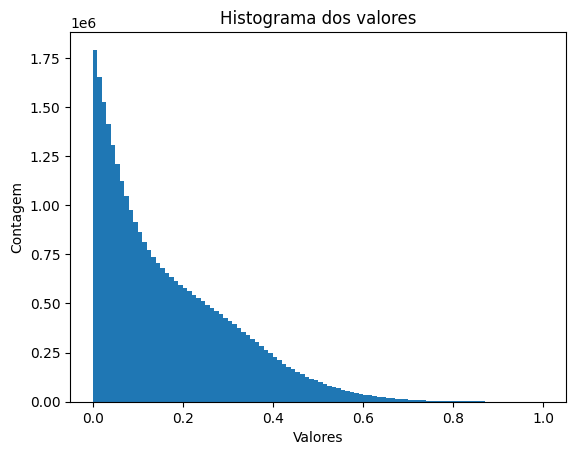

In [181]:
# Criar o histograma
plt.hist(normalized_values.numpy(), bins=100)

# Adicionar título e rótulos aos eixos
plt.title("Histograma dos valores")
plt.xlabel("Valores")
plt.ylabel("Contagem")

# Mostrar o histograma
plt.show()

In [182]:
normalized_values.min(), normalized_values.mean(), normalized_values.median(), normalized_values.max()

(tensor(0.), tensor(1.7027e-01), tensor(1.3081e-01), tensor(1.0000e+00))

In [184]:
%%time
jsonl_cardin = retorna_tokens_texto_e_expansao_jsonl(corpus_expanded_exparse, tokenizer,
                                             lista_doc_id_passage, valor_uma_ocorrencia=0.1)


100%|██████████| 171184/171184 [50:22<00:00, 56.63it/s]

CPU times: user 8h 22min 50s, sys: 1min 5s, total: 8h 23min 56s
Wall time: 50min 23s


In [185]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP = f"{DIRETORIO_CARDIN_MAX}/trec-covid-splade-texto-token-com-rep.jsonl"

In [186]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP_PICKLE = f"{DIRETORIO_TRABALHO}/cardin_corpus_max_texto_token_com_rep.pickle"

In [187]:
with open(CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP_PICKLE, 'wb') as outputFile:
    pickle.dump(jsonl_cardin, outputFile, pickle.HIGHEST_PROTOCOL)

In [188]:
tempo_construcao_indice_splade_lucene_tokenizado_exp_com_rep =  50 * 60 + 23
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene_tokenizado_exp_com_rep}")

Tempo para construir o índice (cpu): 3023


### Gerar índice com texto tokenizado + exp com repet sem pré-processamento
   
      .. entrada: 171mil textos (tokens com valor nos 30mil)
      .. saída: índice lucene


In [ ]:
with open(CAMINHO_CARDIN_MAX_PICKLE, "rb") as f:
  jsonl_cardin = pickle.load(f)

In [189]:
DIRETORIO_CARDIN_MAX,  CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP

('/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max',
 '/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade-texto-token-com-rep.jsonl')

In [190]:
%%time
with open(CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP, 'w') as arquivo:
    for doc in jsonl_cardin:
        # Converte o dicionário em uma string JSON
        linha_json = json.dumps(doc)
        # Escreve a linha JSON no arquivo
        arquivo.write(f'{linha_json}\n')

CPU times: user 2.03 s, sys: 436 ms, total: 2.46 s
Wall time: 2.47 s


In [191]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_COM_REP

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade-texto-token-com-rep.jsonl'

In [195]:
if os.path.exists(DIRETORIO_INDICE):
    shutil.rmtree(DIRETORIO_INDICE)

In [196]:
DIRETORIO_CARDIN_MAX

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max'

In [217]:
DIRETORIO_CARDIN_MAX

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max'

In [197]:
%%time
"""
generator RawDocumentGenerator: sem pré-processamento
        Quando usamos o DefaultLuceneDocumentGenerator, o processo de pré-processamento é aplicado ao texto do documento antes de ser indexado, incluindo a remoção de stopwords, aplicação de stemização, tokenização, entre outros.

        Já com o RawDocumentGenerator, o texto do documento é indexado exatamente como é, sem aplicar nenhum tipo de pré-processamento. Isso significa que a indexação será mais rápida e que as consultas serão feitas diretamente no texto original, sem serem afetadas por nenhum processamento adicional.

        The important indexing options to note here are --impact --pretokenized: the first tells Anserini not to encode BM25 doclengths into Lucene's norms (which is the default) and the second option says not to apply any additional tokenization on the DeepImpact tokens.
                Fonte: https://github.com/castorini/pyserini/blob/master/docs/experiments-deepimpact.md
"""
!python -m pyserini.index.lucene \
        --collection JsonCollection \
        --input {DIRETORIO_CARDIN_MAX} \
        --index {DIRETORIO_INDICE} \
        --threads 9 \
        --storePositions --storeDocvectors \
        --storeRaw  \
        --impact --pretokenized
        
#> /dev/null 2>&1 

2023-05-14 22:28:19,026 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-05-14 22:28:19,027 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-05-14 22:28:19,027 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-05-14 22:28:19,027 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max
2023-05-14 22:28:19,027 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-05-14 22:28:19,027 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-05-14 22:28:19,028 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2023-05-14 22:28:19,028 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: 

In [198]:
tempo_construcao_indice_splade_lucene_tokenizado_exp_com_rep +=  48
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene_tokenizado_exp_com_rep}")

Tempo para construir o índice (cpu): 3071


In [199]:
# Imprimindo estatísticas do índice
index_reader = IndexReader(DIRETORIO_INDICE)
print(index_reader.stats())

{'total_terms': 106079106, 'documents': 171184, 'non_empty_documents': 171184, 'unique_terms': 26801}


In [200]:
searcher = LuceneSearcher(DIRETORIO_INDICE) # './indexes/lucene-index-msmarco-passage')
searcher.set_bm25(k1=1.12, b=0.4)  

In [201]:
import subprocess


In [202]:
tamanho_em_bytes_indice_trecc_splade_tokenizado_exp_com_rep = int(subprocess.check_output(['du', '-b', DIRETORIO_INDICE]).split()[0])


In [203]:
print("O tamanho do índice é:", tamanho_em_bytes_indice_trecc_splade_tokenizado_exp_com_rep, "bytes")



O tamanho do índice é: 868616214 bytes


### Realizar buscas para as queries

#### Sem expansão da query

In [204]:
nome_pipeline = 'splade_cocondenser_max_com_sep_sem_exp_query_lucene_texto_token_repete'

In [205]:
resultado_execucao = {}

In [206]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'cpu', 'valor': tempo_construcao_indice_splade_lucene_tokenizado_exp_com_rep}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade_tokenizado_exp_com_rep
resultado_execucao['se_retrieval_usa_gpu'] = False

In [207]:
se_expande_query = 'N'

In [208]:
tempo_gasto = run_all_queries_lucene_splade(file=CAMINHO_RUN, 
                                     topics=topics,
                                     searcher=searcher,
                                     parm_tokenizer=tokenizer,
                                     parm_se_query_expansion= (se_expande_query == 'S'),
                                     parm_ind_agg_se_query_expansion='max',
                                     parm_num_max_hits=1000)


Running 50 queries in total


### Avaliação latência

In [209]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0578043
std       0.0406180
min       0.0420349
25%       0.0450747
50%       0.0499449
75%       0.0569858
max       0.3319662
Name: tempo_gasto, Length: 8, dtype: float64

In [210]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

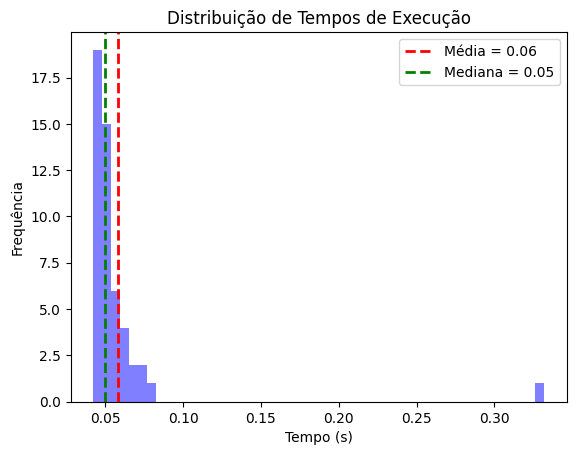

In [211]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

In [215]:
CAMINHO_RUN

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/runs/run-trec-covid.txt'

##### Avaliação métricas

In [212]:

### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")


   query  q0     docid  rank      score       system
0     44  Q0  b2yalnrx     1  16.223000  ComExpansao
1     44  Q0  ugkxxaeb     2  14.199500  ComExpansao
2     44  Q0  gbvyuem5     3  13.616600  ComExpansao
3     44  Q0  e9kroam2     4  13.505800  ComExpansao
4     44  Q0  how1mfvf     5  13.505799  ComExpansao

[5 rows x 6 columns]
NDCG@10: 0.14680575214061553


In [213]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

### Sem repetição de palavras

In [220]:
%%time
jsonl_cardin_sem_rep = retorna_tokens_texto_e_expansao_jsonl(corpus_expanded_exparse, tokenizer,
                                             lista_doc_id_passage, valor_uma_ocorrencia=None)


100%|██████████| 171184/171184 [43:45<00:00, 65.20it/s]

CPU times: user 7h 17min 5s, sys: 32.9 s, total: 7h 17min 38s
Wall time: 43min 45s


In [221]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_SEM_REP = f"{DIRETORIO_CARDIN_MAX}/trec-covid-splade-texto-token-sem-rep.jsonl"

In [222]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_SEM_REP_PICKLE = f"{DIRETORIO_TRABALHO}/cardin_corpus_max_texto_token_sem_rep.pickle"

In [223]:
with open(CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_SEM_REP_PICKLE, 'wb') as outputFile:
    pickle.dump(jsonl_cardin_sem_rep, outputFile, pickle.HIGHEST_PROTOCOL)

In [224]:
%%time
with open(CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_SEM_REP, 'w') as arquivo:
    for doc in jsonl_cardin_sem_rep:
        # Converte o dicionário em uma string JSON
        linha_json = json.dumps(doc)
        # Escreve a linha JSON no arquivo
        arquivo.write(f'{linha_json}\n')

CPU times: user 1.3 s, sys: 204 ms, total: 1.5 s
Wall time: 1.5 s


In [225]:
CAMINHO_CARDIN_MAX_TEXTO_TOKENIZADO_SEM_REP

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade-texto-token-sem-rep.jsonl'

In [226]:
if os.path.exists(DIRETORIO_INDICE):
    shutil.rmtree(DIRETORIO_INDICE)

In [227]:
%%time
"""
generator RawDocumentGenerator: sem pré-processamento
        Quando usamos o DefaultLuceneDocumentGenerator, o processo de pré-processamento é aplicado ao texto do documento antes de ser indexado, incluindo a remoção de stopwords, aplicação de stemização, tokenização, entre outros.

        Já com o RawDocumentGenerator, o texto do documento é indexado exatamente como é, sem aplicar nenhum tipo de pré-processamento. Isso significa que a indexação será mais rápida e que as consultas serão feitas diretamente no texto original, sem serem afetadas por nenhum processamento adicional.

        The important indexing options to note here are --impact --pretokenized: the first tells Anserini not to encode BM25 doclengths into Lucene's norms (which is the default) and the second option says not to apply any additional tokenization on the DeepImpact tokens.
                Fonte: https://github.com/castorini/pyserini/blob/master/docs/experiments-deepimpact.md
"""
!python -m pyserini.index.lucene \
        --collection JsonCollection \
        --input {DIRETORIO_CARDIN_MAX} \
        --index {DIRETORIO_INDICE} \
        --threads 9 \
        --storePositions --storeDocvectors \
        --storeRaw  \
        --impact --pretokenized
        
#> /dev/null 2>&1 

2023-05-14 23:28:41,630 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2023-05-14 23:28:41,631 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: 

In [228]:
# Imprimindo estatísticas do índice
index_reader = IndexReader(DIRETORIO_INDICE)
print(index_reader.stats())

{'total_terms': 67329218, 'documents': 171184, 'non_empty_documents': 171184, 'unique_terms': 26801}


In [229]:
searcher = LuceneSearcher(DIRETORIO_INDICE) # './indexes/lucene-index-msmarco-passage')
searcher.set_bm25(k1=1.12, b=0.4)  

In [230]:
se_expande_query = 'N'

In [231]:
tempo_gasto = run_all_queries_lucene_splade(file=CAMINHO_RUN, 
                                     topics=topics,
                                     searcher=searcher,
                                     parm_tokenizer=tokenizer,
                                     parm_se_query_expansion= (se_expande_query == 'S'),
                                     parm_ind_agg_se_query_expansion='max',
                                     parm_num_max_hits=1000)


Running 50 queries in total


### Avaliação latência

In [232]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0482048
std       0.0073442
min       0.0382822
25%       0.0439157
50%       0.0459208
75%       0.0517323
max       0.0818729
Name: tempo_gasto, Length: 8, dtype: float64

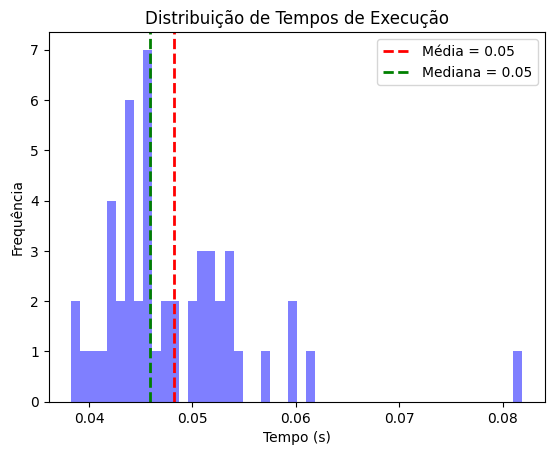

In [233]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação métricas

In [234]:

### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")


   query  q0     docid  rank      score       system
0     44  Q0  b2yalnrx     1  14.035100  ComExpansao
1     44  Q0  ugkxxaeb     2  13.430100  ComExpansao
2     44  Q0  e9kroam2     3  12.773700  ComExpansao
3     44  Q0  how1mfvf     4  12.773699  ComExpansao
4     44  Q0  kmb6128p     5  12.773698  ComExpansao

[5 rows x 6 columns]
NDCG@10: 0.12145534236668482


In [235]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

# Testando corpus sem texto tokenizado

## ind_aggregation = max

In [266]:
ind_agg = 'max'

#### Lendo os dados salvos

In [ ]:
with open(CAMINHO_ARQUIVO_EXPANSAO_MAX, "rb") as f:
  corpus_expanded = pickle.load(f).to_sparse()

In [ ]:
corpus_expanded.shape

torch.Size([171332, 30522])

In [267]:
corpus_expanded[3]

tensor(indices=tensor([[ 2023,  2563,  2773,  2888,  2966,  3656,  3659,  4074,
                         4172,  4295,  4422,  4789,  5081,  5125,  5292,  5305,
                         5965,  6108,  6210,  6213,  6425,  6426,  6647,  6796,
                         7004,  7240,  7305,  7355,  7366,  7482,  7865,  7870,
                         8761,  8764,  8925,  8985,  9820,  9895,  9999, 10178,
                        11798, 11829, 14765, 15403, 16311, 18583, 19108, 19340,
                        19857, 22498, 24442, 26835, 28389]]),
       values=tensor([8.1596e-01, 3.9217e-02, 8.8719e-02, 5.2040e-01,
                      3.6793e-01, 3.9014e-02, 9.8482e-02, 1.5676e+00,
                      1.1148e-02, 1.0893e+00, 2.8933e-01, 3.3384e-01,
                      3.0651e-01, 1.9354e-03, 1.2646e-01, 3.4454e-02,
                      3.2749e-01, 1.5451e-01, 1.6557e-01, 4.3859e-02,
                      3.0756e-01, 3.7101e-01, 4.8870e-01, 4.6626e-01,
                      2.5939e-01, 1.24

### Gerar corpus com texto 
   
      .. entrada: corpus_extensao 171332 x 30522
      .. saida:   lista com 171332 textos (tokens com valor nos 30mil)


#### Um tensor pequeno para teste

In [268]:
corpus_expanded.shape # torch.Size([171332, 30522])

torch.Size([171184, 30522])

In [269]:
corpus_expanded_min = corpus_expanded.to_dense()[1000:1003].to_sparse()

In [270]:
corpus_expanded_min.shape

torch.Size([3, 30522])

In [292]:
%%time
jsonl_cardin_com_repeticao = retorna_tokens_expansao_jsonl(corpus_expanded_min, tokenizer, lista_doc_id_passage[1000:1003], valor_uma_ocorrencia=0.05)


100%|██████████| 3/3 [00:00<00:00, 1306.23it/s]

CPU times: user 4.74 ms, sys: 44 µs, total: 4.79 ms
Wall time: 4.49 ms


In [293]:
print(jsonl_cardin_com_repeticao[2])

{'id': '3ij83et1', 'contents': ' .  .  the  the  he  he  team  team  film  film  man  man  series  series  game  game  species  species  player  player  god  god  character  character  henry  henry  japan  japan  kill  kill  movie  movie  actor  actor  champion  champion  founder  founder  murder  murder  website  website  alex  alex  animal  animal  disease  disease  drug  drug  vampire  vampire  hunter  hunter  evil  evil  threat  threat  victor  victor  weapon  weapon  soldier  soldier  hero  hero  ghost  ghost  hunting  hunting  monster  monster  killer  killer  marcus  marcus  perry  perry  genre  genre  witch  witch  nathan  nathan  alien  alien  survival  survival  virus  virus  fake  fake  creator  creator  fisher  fisher  robot  robot  infection  infection  griffin  griffin  savage  savage  hunters  hunters  hawk  hawk  eden  eden  zombie  zombie  bug  bug  survivor  survivor  marty  marty  viral  viral  predator  predator  epidemic  epidemic  vaccine  vaccine  viruses  viruse

Antes de ter repetições

{'id': '3ij83et1', 'contents': '. the he team film man series game species player god character henry japan kill movie actor champion founder murder website alex animal disease drug vampire hunter evil threat victor weapon soldier hero ghost hunting monster killer marcus perry genre witch nathan alien survival virus fake creator fisher robot infection griffin savage hunters hawk eden zombie bug survivor marty viral predator epidemic vaccine viruses parasite mosquito pathogen'}

In [294]:
print(corpus[1002])

{'_id': '3ij83et1', 'title': 'The virus hunter.', 'text': '', 'metadata': {'url': 'https://www.ncbi.nlm.nih.gov/pubmed/14576238/', 'pubmed_id': '14576238'}, 'texto_titulo': 'The virus hunter.. '}


#### Rodando para todos

In [282]:
normalized_values = (corpus_expanded_exparse._values() - corpus_expanded_exparse._values().min()) / (corpus_expanded_exparse._values().max() - corpus_expanded_exparse._values().min())


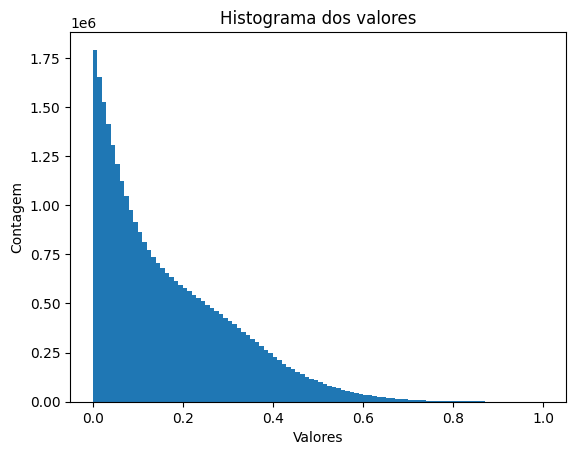

In [285]:
# Criar o histograma
plt.hist(normalized_values.numpy(), bins=100)

# Adicionar título e rótulos aos eixos
plt.title("Histograma dos valores")
plt.xlabel("Valores")
plt.ylabel("Contagem")

# Mostrar o histograma
plt.show()

In [284]:
normalized_values.min(), normalized_values.mean(), normalized_values.median(), normalized_values.max()

(tensor(0.), tensor(1.7027e-01), tensor(1.3081e-01), tensor(1.0000e+00))

In [295]:
%%time
jsonl_cardin = retorna_tokens_expansao_jsonl(corpus_expanded.to_sparse(), tokenizer,
                                             lista_doc_id_passage, valor_uma_ocorrencia=0.05)


100%|██████████| 171184/171184 [50:19<00:00, 56.68it/s]

CPU times: user 8h 22min 21s, sys: 1min 4s, total: 8h 23min 26s
Wall time: 50min 20s


In [296]:
with open(CAMINHO_CARDIN_MAX_PICKLE, 'wb') as outputFile:
    pickle.dump(jsonl_cardin, outputFile, pickle.HIGHEST_PROTOCOL)

In [298]:
tempo_construcao_indice_splade_lucene =  50 * 60 + 20
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene}")

Tempo para construir o índice (cpu): 3020


### Gerar índice com texto sem pré-processamento
   
      .. entrada: 171mil textos (tokens com valor nos 30mil)
      .. saída: índice lucene


In [423]:
with open(CAMINHO_CARDIN_MAX_PICKLE, "rb") as f:
  jsonl_cardin = pickle.load(f)

In [305]:
DIRETORIO_CARDIN_MAX,  CAMINHO_CARDIN_MAX

('/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max',
 '/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade.jsonl')

In [302]:
%%time
with open(CAMINHO_CARDIN_MAX, 'w') as arquivo:
    for doc in jsonl_cardin:
        # Converte o dicionário em uma string JSON
        linha_json = json.dumps(doc)
        # Escreve a linha JSON no arquivo
        arquivo.write(f'{linha_json}\n')

CPU times: user 1.55 s, sys: 340 ms, total: 1.89 s
Wall time: 1.89 s


In [303]:
CAMINHO_CARDIN_MAX

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade.jsonl'

In [ ]:
if os.path.exists(DIRETORIO_INDICE):
    shutil.rmtree(DIRETORIO_INDICE)

In [310]:
%%time
"""
generator RawDocumentGenerator: sem pré-processamento
        Quando usamos o DefaultLuceneDocumentGenerator, o processo de pré-processamento é aplicado ao texto do documento antes de ser indexado, incluindo a remoção de stopwords, aplicação de stemização, tokenização, entre outros.

        Já com o RawDocumentGenerator, o texto do documento é indexado exatamente como é, sem aplicar nenhum tipo de pré-processamento. Isso significa que a indexação será mais rápida e que as consultas serão feitas diretamente no texto original, sem serem afetadas por nenhum processamento adicional.

        The important indexing options to note here are --impact --pretokenized: the first tells Anserini not to encode BM25 doclengths into Lucene's norms (which is the default) and the second option says not to apply any additional tokenization on the DeepImpact tokens.
                Fonte: https://github.com/castorini/pyserini/blob/master/docs/experiments-deepimpact.md
"""
!python -m pyserini.index.lucene \
        --collection JsonCollection \
        --input {DIRETORIO_CARDIN_MAX} \
        --index {DIRETORIO_INDICE} \
        --threads 9 \
        --storePositions --storeDocvectors \
        --storeRaw  \
        --impact --pretokenized
        
#> /dev/null 2>&1 

2023-05-10 00:22:45,170 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-05-10 00:22:45,171 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-05-10 00:22:45,171 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-05-10 00:22:45,172 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max
2023-05-10 00:22:45,172 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-05-10 00:22:45,172 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-05-10 00:22:45,172 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2023-05-10 00:22:45,172 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: 

In [311]:
tempo_construcao_indice_splade_lucene +=  33
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene}")

Tempo para construir o índice (cpu): 3053


In [312]:
# Imprimindo estatísticas do índice
index_reader = IndexReader(DIRETORIO_INDICE)
print(index_reader.stats())

{'total_terms': 61882602, 'documents': 171184, 'non_empty_documents': 171184, 'unique_terms': 26245}


In [314]:
searcher = LuceneSearcher(DIRETORIO_INDICE) # './indexes/lucene-index-msmarco-passage')
searcher.set_bm25(k1=1.12, b=0.4)  

In [316]:
import subprocess


In [317]:
tamanho_em_bytes_indice_trecc_splade = int(subprocess.check_output(['du', '-b', DIRETORIO_INDICE]).split()[0])


In [318]:
print("O tamanho do índice é:", tamanho_em_bytes_indice_trecc_splade, "bytes")



O tamanho do índice é: 587578693 bytes


### Realizar buscas para as queries

#### Sem expansão da query

In [361]:
nome_pipeline = 'splade_cocondenser_max_com_sep_sem_exp_query_lucene_repete'

In [362]:
resultado_execucao = {}

In [363]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'gpu', 'valor': tempo_construcao_indice_splade}, {'tipo':'cpu', 'valor': tempo_construcao_indice_splade_lucene}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade
resultado_execucao['se_retrieval_usa_gpu'] = False

In [364]:
se_expande_query = 'N'

In [365]:
tempo_gasto = run_all_queries_lucene_splade(file=CAMINHO_RUN, 
                                     topics=topics,
                                     searcher=searcher,
                                     parm_tokenizer=tokenizer,
                                     parm_se_query_expansion= (se_expande_query == 'S'),
                                     parm_ind_agg_se_query_expansion='max',
                                     parm_num_max_hits=1000)


Running 50 queries in total


### Avaliação latência

In [366]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0401389
std       0.0037447
min       0.0360098
25%       0.0374627
50%       0.0393313
75%       0.0415176
max       0.0557473
Name: tempo_gasto, Length: 8, dtype: float64

In [367]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

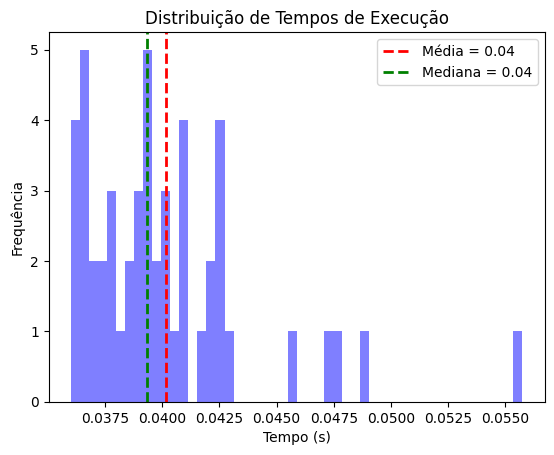

In [368]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação métricas

In [369]:

### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")


   query  q0     docid  rank      score       system
0     44  Q0  b2yalnrx     1  17.224400  ComExpansao
1     44  Q0  hwl5fsu1     2  14.098300  ComExpansao
2     44  Q0  srkd3wh0     3  14.098299  ComExpansao
3     44  Q0  dsmdqp2o     4  13.926200  ComExpansao
4     44  Q0  tstx42h7     5  13.607900  ComExpansao

[5 rows x 6 columns]
NDCG@10: 0.17127746121542514


In [370]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [371]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(f"resultado_pipeline[{nome_pipeline}] {resultado_pipeline[nome_pipeline]}")

resultado_pipeline[splade_cocondenser_max_com_sep_sem_exp_query_lucene_repete] {'tempo_indexacao_segundo': [{'tipo': 'gpu', 'valor': 1470}, {'tipo': 'cpu', 'valor': 3053}], 'memoria_indice_byte_ram': 587578693, 'se_retrieval_usa_gpu': False, 'retrieval_tempo_medio_por_query': 0.040139, 'ndcg_10': 17.13}


In [ ]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

{'utilizacao_perfeita': {'usd_query': 3.65e-07, 'usd_dia': 0.785658393470592, 'usd_gpu_dia': 0, 'usd_mes': 23.569751804117757, 'usd_indexacao_tempo': 0.037690159}, 'utilizacao_precaria_100': {'usd_query': 0.0078565839, 'usd_dia': 0.785658393470592, 'usd_gpu_dia': 0, 'usd_mes': 23.569751804117757, 'usd_indexacao_tempo': 0.037690159}}


### Sem repetição de palavras

In [384]:
%%time
jsonl_cardin = retorna_tokens_expansao_jsonl(corpus_expanded.to_sparse(), tokenizer,
                                             lista_doc_id_passage, valor_uma_ocorrencia=None)


100%|██████████| 171184/171184 [43:55<00:00, 64.94it/s]


CPU times: user 7h 19min 1s, sys: 28.2 s, total: 7h 19min 30s
Wall time: 43min 56s


In [386]:
tempo_construcao_indice_splade_lucene =  43 * 60 + 56
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene}")

Tempo para construir o índice (cpu): 2636


### Gerar índice com texto sem pré-processamento
   
      .. entrada: 171mil textos (tokens com valor nos 30mil)
      .. saída: índice lucene


In [ ]:
with open(CAMINHO_CARDIN_MAX_PICKLE, "rb") as f:
  jsonl_cardin = pickle.load(f)

In [ ]:
DIRETORIO_CARDIN_MAX,  CAMINHO_CARDIN_MAX

('/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max',
 '/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade.jsonl')

In [387]:
 f"{CAMINHO_CARDIN_MAX}-sem-repeticao"

'/home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max/trec-covid-splade.jsonl_sem_repeticao'

In [388]:
%%time
with open(f"{CAMINHO_CARDIN_MAX}", 'w') as arquivo:
    for doc in jsonl_cardin:
        # Converte o dicionário em uma string JSON
        linha_json = json.dumps(doc)
        # Escreve a linha JSON no arquivo
        arquivo.write(f'{linha_json}\n')

CPU times: user 807 ms, sys: 192 ms, total: 999 ms
Wall time: 1 s


In [389]:
if os.path.exists(DIRETORIO_INDICE):
    shutil.rmtree(DIRETORIO_INDICE)

In [390]:
%%time
"""
generator RawDocumentGenerator: sem pré-processamento
        Quando usamos o DefaultLuceneDocumentGenerator, o processo de pré-processamento é aplicado ao texto do documento antes de ser indexado, incluindo a remoção de stopwords, aplicação de stemização, tokenização, entre outros.

        Já com o RawDocumentGenerator, o texto do documento é indexado exatamente como é, sem aplicar nenhum tipo de pré-processamento. Isso significa que a indexação será mais rápida e que as consultas serão feitas diretamente no texto original, sem serem afetadas por nenhum processamento adicional.

        The important indexing options to note here are --impact --pretokenized: the first tells Anserini not to encode BM25 doclengths into Lucene's norms (which is the default) and the second option says not to apply any additional tokenization on the DeepImpact tokens.
                Fonte: https://github.com/castorini/pyserini/blob/master/docs/experiments-deepimpact.md
"""
!python -m pyserini.index.lucene \
        --collection JsonCollection \
        --input {DIRETORIO_CARDIN_MAX} \
        --index {DIRETORIO_INDICE} \
        --threads 9 \
        --storePositions --storeDocvectors \
        --storeRaw  \
        --impact --pretokenized
        
#> /dev/null 2>&1 

2023-05-10 09:29:41,192 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2023-05-10 09:29:41,193 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: 

In [391]:
tempo_construcao_indice_splade_lucene +=  33
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene}")

Tempo para construir o índice (cpu): 2669


In [392]:
# Imprimindo estatísticas do índice
index_reader = IndexReader(DIRETORIO_INDICE)
print(index_reader.stats())

{'total_terms': 61882602, 'documents': 171184, 'non_empty_documents': 171184, 'unique_terms': 26245}


In [393]:
searcher = LuceneSearcher(DIRETORIO_INDICE) # './indexes/lucene-index-msmarco-passage')
searcher.set_bm25(k1=1.12, b=0.4)  

In [394]:
tamanho_em_bytes_indice_trecc_splade = int(subprocess.check_output(['du', '-b', DIRETORIO_INDICE]).split()[0])


In [395]:
print("O tamanho do índice é:", tamanho_em_bytes_indice_trecc_splade, "bytes")



O tamanho do índice é: 587578693 bytes


In [396]:
nome_pipeline = 'splade_max_com_sep_sem_exp_query_lucene'

In [397]:
resultado_execucao = {}

In [398]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'gpu', 'valor': tempo_construcao_indice_splade}, {'tipo':'cpu', 'valor': tempo_construcao_indice_splade_lucene}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade
resultado_execucao['se_retrieval_usa_gpu'] = False

In [399]:
se_expande_query = 'N'

In [400]:
tempo_gasto = run_all_queries_lucene_splade(file=CAMINHO_RUN, 
                                     topics=topics,
                                     searcher=searcher,
                                     parm_tokenizer=tokenizer,
                                     parm_se_query_expansion= (se_expande_query == 'S'),
                                     parm_ind_agg_se_query_expansion='max',
                                     parm_num_max_hits=1000)


Running 50 queries in total


### Avaliação latência

In [401]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0421948
std       0.0086744
min       0.0357292
25%       0.0387312
50%       0.0399827
75%       0.0426190
max       0.0912654
Name: tempo_gasto, Length: 8, dtype: float64

In [402]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

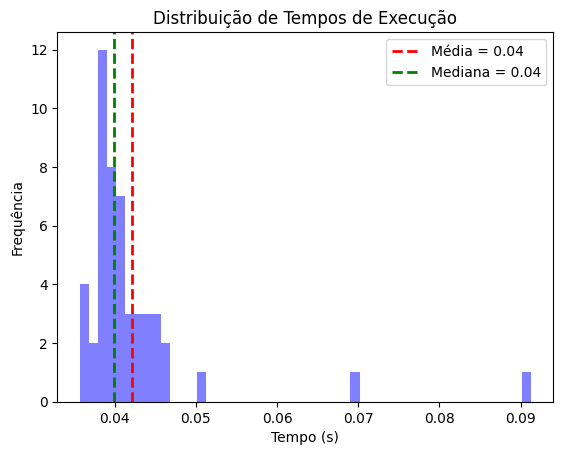

In [403]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação métricas

In [404]:

### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")


   query  q0     docid  rank      score       system
0     44  Q0  b2yalnrx     1  17.224400  ComExpansao
1     44  Q0  hwl5fsu1     2  14.098300  ComExpansao
2     44  Q0  srkd3wh0     3  14.098299  ComExpansao
3     44  Q0  dsmdqp2o     4  13.926200  ComExpansao
4     44  Q0  tstx42h7     5  13.607900  ComExpansao

[5 rows x 6 columns]
NDCG@10: 0.17127746121542514


In [405]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [406]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(f"resultado_pipeline[{nome_pipeline}] {resultado_pipeline[nome_pipeline]}")

resultado_pipeline[splade_max_com_sep_sem_exp_query_lucene] {'tempo_indexacao_segundo': [{'tipo': 'gpu', 'valor': 1470}, {'tipo': 'cpu', 'valor': 2669}], 'memoria_indice_byte_ram': 587578693, 'se_retrieval_usa_gpu': False, 'retrieval_tempo_medio_por_query': 0.042195, 'ndcg_10': 17.13}


In [407]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

{'utilizacao_perfeita': {'usd_query': 3.837e-07, 'usd_dia': 0.785658393470592, 'usd_gpu_dia': 0, 'usd_mes': 23.569751804117757, 'usd_indexacao_tempo': 0.034490287}, 'utilizacao_precaria_100': {'usd_query': 0.0078565839, 'usd_dia': 0.785658393470592, 'usd_gpu_dia': 0, 'usd_mes': 23.569751804117757, 'usd_indexacao_tempo': 0.034490287}}


## Texto mais palavras geradas sem repetição 

In [426]:
%%time
with open(f"{CAMINHO_CARDIN_MAX}", 'w') as arquivo:
    for doc in jsonl_cardin:
        # print(corpus_dict[doc['id']])
        doc['contents'] =  corpus_dict[doc['id']]['texto_titulo'] +  doc['contents']
        #print(texto)
        #print(doc)
        #break
        # Converte o dicionário em uma string JSON
        linha_json = json.dumps(doc)
        # Escreve a linha JSON no arquivo
        arquivo.write(f'{linha_json}\n')

CPU times: user 2.04 s, sys: 699 ms, total: 2.74 s
Wall time: 7.06 s


In [427]:
if os.path.exists(DIRETORIO_INDICE):
    shutil.rmtree(DIRETORIO_INDICE)

In [428]:
%%time
"""
generator RawDocumentGenerator: sem pré-processamento
        Quando usamos o DefaultLuceneDocumentGenerator, o processo de pré-processamento é aplicado ao texto do documento antes de ser indexado, incluindo a remoção de stopwords, aplicação de stemização, tokenização, entre outros.

        Já com o RawDocumentGenerator, o texto do documento é indexado exatamente como é, sem aplicar nenhum tipo de pré-processamento. Isso significa que a indexação será mais rápida e que as consultas serão feitas diretamente no texto original, sem serem afetadas por nenhum processamento adicional.

        The important indexing options to note here are --impact --pretokenized: the first tells Anserini not to encode BM25 doclengths into Lucene's norms (which is the default) and the second option says not to apply any additional tokenization on the DeepImpact tokens.
                Fonte: https://github.com/castorini/pyserini/blob/master/docs/experiments-deepimpact.md
"""
!python -m pyserini.index.lucene \
        --collection JsonCollection \
        --input {DIRETORIO_CARDIN_MAX} \
        --index {DIRETORIO_INDICE} \
        --generator DefaultLuceneDocumentGenerator \
        --threads 9 \
        --storePositions --storeDocvectors \
        --storeRaw  
        
#> /dev/null 2>&1 

2023-05-10 09:45:07,721 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2023-05-10 09:45:07,722 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2023-05-10 09:45:07,722 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2023-05-10 09:45:07,722 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: /home/borela/fontes/deep_learning_em_buscas_unicamp/local/tradeoff/cardin_splade_max
2023-05-10 09:45:07,722 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2023-05-10 09:45:07,723 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2023-05-10 09:45:07,723 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2023-05-10 09:45:07,723 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: 

In [429]:
tempo_construcao_indice_splade_lucene +=  (52 - 33) # 33 já havia somado antes
print(f"Tempo para construir o índice (cpu): {tempo_construcao_indice_splade_lucene}")

Tempo para construir o índice (cpu): 2688


In [430]:
# Imprimindo estatísticas do índice
index_reader = IndexReader(DIRETORIO_INDICE)
print(index_reader.stats())

{'total_terms': 81391138, 'documents': 171184, 'non_empty_documents': 171184, 'unique_terms': 204958}


In [431]:
searcher = LuceneSearcher(DIRETORIO_INDICE) # './indexes/lucene-index-msmarco-passage')
searcher.set_bm25(k1=1.12, b=0.4)  

In [432]:
tamanho_em_bytes_indice_trecc_splade = int(subprocess.check_output(['du', '-b', DIRETORIO_INDICE]).split()[0])


In [433]:
print("O tamanho do índice é:", tamanho_em_bytes_indice_trecc_splade, "bytes")



O tamanho do índice é: 784228554 bytes


In [434]:
nome_pipeline = 'splade_max_com_sep_sem_exp_query_lucene_texto_exp'

In [435]:
resultado_execucao = {}

In [436]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'gpu', 'valor': tempo_construcao_indice_splade}, {'tipo':'cpu', 'valor': tempo_construcao_indice_splade_lucene}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade
resultado_execucao['se_retrieval_usa_gpu'] = False

In [437]:
se_expande_query = 'N'

In [438]:
tempo_gasto = run_all_queries_lucene_splade(file=CAMINHO_RUN, 
                                     topics=topics,
                                     searcher=searcher,
                                     parm_tokenizer=tokenizer,
                                     parm_se_query_expansion= (se_expande_query == 'S'),
                                     parm_ind_agg_se_query_expansion='max',
                                     parm_num_max_hits=1000)


Running 50 queries in total


### Avaliação latência

In [439]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.0000000
mean      0.0526775
std       0.0076584
min       0.0430920
25%       0.0468504
50%       0.0521983
75%       0.0560415
max       0.0846241
Name: tempo_gasto, Length: 8, dtype: float64

In [440]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

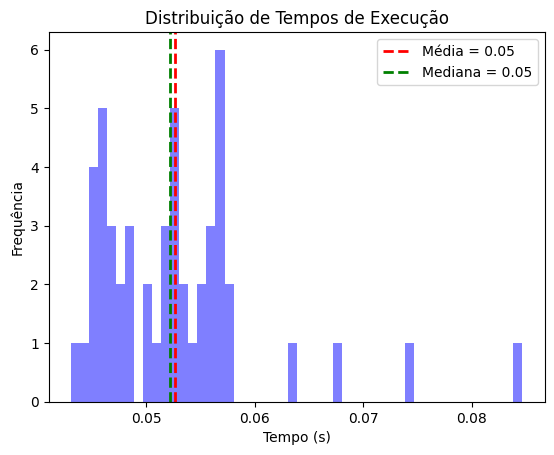

In [441]:
# Calculando média e mediana
media = df_tempos['tempo_gasto'].mean()
mediana = df_tempos['tempo_gasto'].median()

# Plotando gráfico
fig, ax = plt.subplots()
ax.hist(df_tempos['tempo_gasto'], bins=50, color='blue', alpha=0.5)
ax.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media:.2f}')
ax.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Tempos de Execução')
ax.legend()
plt.show()

##### Avaliação métricas

In [442]:

### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

results = trec_eval.compute(predictions=[run], references=[qrel_dict])

# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")


   query  q0     docid  rank    score       system
0     44  Q0  b2yalnrx     1  14.4799  ComExpansao
1     44  Q0  ugkxxaeb     2  12.5132  ComExpansao
2     44  Q0  imv1ygf6     3  11.8220  ComExpansao
3     44  Q0  9o0sjnml     4  11.3887  ComExpansao
4     44  Q0  yx9oa2ra     5  11.3818  ComExpansao

[5 rows x 6 columns]
NDCG@10: 0.42308970533046614


In [443]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [444]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(f"resultado_pipeline[{nome_pipeline}] {resultado_pipeline[nome_pipeline]}")

resultado_pipeline[splade_max_com_sep_sem_exp_query_lucene_texto_exp] {'tempo_indexacao_segundo': [{'tipo': 'gpu', 'valor': 1470}, {'tipo': 'cpu', 'valor': 2688}], 'memoria_indice_byte_ram': 784228554, 'se_retrieval_usa_gpu': False, 'retrieval_tempo_medio_por_query': 0.052678, 'ndcg_10': 42.31}


In [445]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

{'utilizacao_perfeita': {'usd_query': 4.924e-07, 'usd_dia': 0.807632835538176, 'usd_gpu_dia': 0, 'usd_mes': 24.22898506614528, 'usd_indexacao_tempo': 0.034648614}, 'utilizacao_precaria_100': {'usd_query': 0.0080763284, 'usd_dia': 0.807632835538176, 'usd_gpu_dia': 0, 'usd_mes': 24.22898506614528, 'usd_indexacao_tempo': 0.034648614}}


# EXPERIMENTAR COM RERANKING

In [461]:
from torch.utils.data import DataLoader

In [462]:
from torch.utils.data import Dataset

In [463]:
from transformers import BatchEncoding

In [464]:
class MyDataset(Dataset):
    """
      Classe para representar um dataset de texto e classes.
    """  
    def __init__(self, texts: list, classes:list[int], tokenizer):
      """
      Inicializa um novo objeto MyDataset.

      Args:
          texts (list): uma lista com as strings de texto. Cada elemento deve ter 2 strings.
          classes (np.ndarray): um array com as classes de cada texto.
          tokenizer: um objeto tokenizer do Hugging Face Transformers.
          max_seq_length (int): o tamanho máximo da sequência a ser considerado.
      Raises:
          AssertionError: se os parâmetros não estiverem no formato esperado.
      """
      # Verifica se os parâmetros são do tipo esperado
      assert isinstance(texts, list), f"Parâmetro texts deve ser do tipo list e não {type(texts)}"
      for row in texts:
          assert isinstance(row, tuple) and len(row)== 2, f"Each row in texts must have 2 elements"
          assert isinstance(row[0], str) and isinstance(row[1], str), f"Each element in texts.row must be a string e não {type(row[0])}"
      assert isinstance(classes,np.ndarray), f'classes deve ser do tipo np.ndarray e não {type(classes)}'
      assert isinstance(classes[0],np.int64), f'classes[0] deve ser do tipo numpy.int64 e não {type(classes[0])} '

      self.texts = texts
      self.classes = classes
      self.tokenizer = tokenizer
      self.max_seq_length = tokenizer.model_max_length # model.config.max_position_embeddings
      if self.max_seq_length > 64000:
        print(f"Valor de self.max_seq_length  {self.max_seq_length} indica que deve ser usado outro campo do tokenizador. Assumido 512 ")
        self.max_seq_length =  512
      # Salvar os dados dos tensores
      x_data_input_ids = []
      x_data_token_type_ids = []
      x_data_attention_masks = []
      for text_pair in texts:
          encoding = tokenizer.encode_plus(
              text_pair[0],
              text_pair[1],
              add_special_tokens=True,
              max_length=self.max_seq_length,
              padding='max_length',
              return_tensors = 'pt',
              truncation=True,
              return_attention_mask=True,
              return_token_type_ids=True
          )
          x_data_input_ids.append(encoding['input_ids'].long())
          x_data_token_type_ids.append(encoding['token_type_ids'].long())
          x_data_attention_masks.append(encoding['attention_mask'].long())
      # print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      # squeeze: vai transformar um tensor de shape [2, 1, 322] em um tensor de shape [2, 322].

      self.x_tensor_input_ids = torch.stack(x_data_input_ids).squeeze(1)
      self.x_tensor_attention_masks = torch.stack(x_data_attention_masks).squeeze(1)
      self.x_tensor_token_type_ids = torch.stack(x_data_token_type_ids).squeeze(1)

    def __len__(self):
        """
          Retorna o tamanho do dataset (= tamanho do array texts)
        """
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
          Retorna um dicionário com os dados do texto e sua classe correspondente, em um formato que pode 
          ser usado pelo dataloader do PyTorch para alimentar um modelo de aprendizado de máquina.
        """
        return {
            'input_ids': self.x_tensor_input_ids[idx],
            'attention_mask': self.x_tensor_attention_masks[idx],
            'token_type_ids': self.x_tensor_token_type_ids[idx],
            # 'labels': int(self.classes[idx])
            'labels': torch.tensor(self.classes[idx], dtype=torch.long)            
        }

In [482]:
def calcula_relevancia(parm_model, parm_dataloader_reranking, parm_model_name:str):
  # para 'cross-encoder/ms-marco-TinyBERT-L-2'
  prob_relevancia = []
  parm_model.eval()
  nome_modelo = parm_model_name.lower()
  with torch.no_grad():
      for ndx, batch in enumerate(parm_dataloader_reranking):
          if 'minilm' in nome_modelo:
              logits_model = parm_model(**BatchEncoding(batch).to(device)).logits                          
              relevantes_float = [float(t) for t in logits_model]
          elif 'monobert' in nome_modelo:
              logits_model = parm_model(**BatchEncoding(batch).to(device)).logits
              probs = torch.nn.functional.softmax(logits_model, dim=1)
              nao_relevante, relevante = zip(*probs)
              relevantes_float = [float(t) for t in relevante]              
          prob_relevancia.extend(relevantes_float)          
          # prob_relevancia.append(pa.array(scores.numpy()))
  return prob_relevancia

In [486]:
def run_all_queries_splade_reranking(parm_model:BertForMaskedLM,
                                    parm_tokenizer:BertTokenizer, 
                                    parm_model_ranking:AutoModelForSequenceClassification,
                                    parm_model_ranking_name:str,
                                    parm_tokenizer_ranking:AutoTokenizer,
                                    parm_dict_queries:{},
                                    parm_corpus_expanded, 
                                    parm_lista_doc_id_passage:list,
                                    parm_num_max_hits:int=1000,
                                    parm_se_query_expansion:bool=False,
                                    parm_ind_agg_se_query_expansion:str=None,
                                    parm_se_usa_sep_query_expansion: bool = True):
    assert parm_ind_agg_se_query_expansion and parm_se_query_expansion or not parm_se_query_expansion, \
        f"se parm_se_query_expansion {parm_se_query_expansion} for True, deve-se informar parm_ind_agg_se_query_expansion {parm_ind_agg_se_query_expansion}"
    tempos = []
    with open(CAMINHO_RUN, 'w') as runfile:
        for cnt, (query_id, value) in enumerate(parm_dict_queries.items()):
            # print(id, value)
            tempo_inicio = time.time()
            if parm_se_query_expansion:
                query_scores = retorna_subword_importante(parm_model=parm_model,
                                                parm_tokenizer=parm_tokenizer,
                                                parm_sentences=[value['question']], 
                                                parm_ind_agg=parm_ind_agg_se_query_expansion, parm_se_usa_sep=parm_se_usa_sep_query_expansion).to_dense().squeeze().to(device)
            else:
                query_scores = retorna_tensor_unitario_em_tokens(parm_tokenizer, value['question']).to(device)

            # Pega os primeiros 1000 resultados
            score = torch.matmul(parm_corpus_expanded, query_scores)
            # Ordena
            sorted_score, indices_score = torch.sort(score, descending=True)

            # parm_num_max_hits primeiros
            sorted_score = sorted_score[0:parm_num_max_hits]
            indices_score = indices_score[0:parm_num_max_hits]

            if cnt % 5 == 0:
                print(f'{cnt} queries completadas')

            # ids dos documentos
            docids = [parm_lista_doc_id_passage[i] for i in indices_score]

            pares_texto = [(value['question'], corpus_dict[docid]['texto_titulo']) for docid in docids]

            # print("carregando dataset")  
            classes_dummy = np.zeros(len(docids), dtype=np.int64)
            dataset_reranking = MyDataset(texts=pares_texto, classes=classes_dummy, tokenizer=parm_tokenizer_ranking)    
            dataloader_reranking = DataLoader(dataset_reranking,
                                            batch_size= 16,
                                            shuffle=False)
            prob_relevancia = calcula_relevancia(parm_model_ranking, dataloader_reranking, parm_model_name = parm_model_ranking_name)
            resultado_ordenado = sorted(zip(docids, prob_relevancia), key=lambda x: x[1], reverse=True)
            tempos.append(time.time() - tempo_inicio)

            for i in range(0, len(docids)):
                _ = runfile.write(f'{query_id} Q0 {resultado_ordenado[i][0]} {i+1} {resultado_ordenado[i][1]:.6f} Busca\n')
            cnt += 1
            if cnt % 100 == 0:
                print(f'{cnt} queries completed')


    return tempos

# Reranking com miniLM (treinado no ms-marco)

In [451]:
# Limpa o cache da memória da GPU
torch.cuda.empty_cache()

In [449]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [470]:
# nome_modelo = 'cross-encoder/ms-marco-TinyBERT-L-2'
nome_modelo_ranking = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
model_ranking = AutoModelForSequenceClassification.from_pretrained(nome_modelo).to(device)
tokenizer_ranking = AutoTokenizer.from_pretrained(nome_modelo)

In [471]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 509, 512)

## bm25@100_reranking_minilm

In [512]:
se_expande_query = 'S'

In [513]:
nome_pipeline = 'splade@100_reranking_minilm'

In [514]:
resultado_execucao = {}

In [515]:
tempo_construcao_indice_splade, tamanho_em_bytes_indice_trecc_splade

(1470, 784228554)

In [516]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'cpu', 'valor': tempo_construcao_indice_splade}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade
resultado_execucao['se_retrieval_usa_gpu'] = True

In [517]:
%%time
tempo_gasto = run_all_queries_splade_reranking(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_model_ranking=model_ranking,
                                    parm_model_ranking_name=nome_modelo_ranking,
                                    parm_tokenizer_ranking=tokenizer_ranking, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded_exparse, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=100,
                                    parm_se_query_expansion= (se_expande_query == 'S'),
                                    parm_ind_agg_se_query_expansion='max', 
                                    parm_se_usa_sep_query_expansion=True)

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 1min 40s, sys: 1.04 s, total: 1min 41s
Wall time: 17.8 s


In [518]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)
print(f"Tempo médio por query {resultado_execucao['retrieval_tempo_medio_por_query']}")

Tempo médio por query 0.354909


In [519]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

   query  q0     docid  rank     score system
0     44  Q0  yx9oa2ra     1  7.613322  Busca
1     44  Q0  qi1henyy     2  6.995133  Busca
2     44  Q0  28utunid     3  6.964627  Busca
3     44  Q0  ej76fsxa     4  6.382739  Busca
4     44  Q0  uc37poce     5  6.346030  Busca

[5 rows x 6 columns]


In [520]:
results = trec_eval.compute(predictions=[run], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")

NDCG@10: 0.7067857765212073
Resultados: {'runid': 'Busca', 'num_ret': 5000, 'num_rel': 24673, 'num_rel_ret': 2850, 'num_q': 50, 'map': 0.09771551161783593, 'gm_map': 0.08199619651346489, 'bpref': 0.1274160329442371, 'Rprec': 0.13118317655785894, 'recip_rank': 0.8823333333333332, 'P@5': 0.7919999999999999, 'P@10': 0.7660000000000001, 'P@15': 0.7666666666666667, 'P@20': 0.7620000000000001, 'P@30': 0.7266666666666667, 'P@100': 0.5700000000000001, 'P@200': 0.28500000000000003, 'P@500': 0.114, 'P@1000': 0.057, 'NDCG@5': 0.7273094568392318, 'NDCG@10': 0.7067857765212073, 'NDCG@15': 0.7017124874325529, 'NDCG@20': 0.6942656795518224, 'NDCG@30': 0.6703306429072416, 'NDCG@100': 0.5467578084041811, 'NDCG@200': 0.33998534006730446, 'NDCG@500': 0.22567715853008458, 'NDCG@1000': 0.21194464794056678}


In [521]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [522]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(resultado_pipeline[nome_pipeline])

{'tempo_indexacao_segundo': [{'tipo': 'cpu', 'valor': 1470}], 'memoria_indice_byte_ram': 784228554, 'se_retrieval_usa_gpu': True, 'retrieval_tempo_medio_por_query': 0.354909, 'ndcg_10': 70.68}


In [523]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

para utilizacao_perfeita custo gpu dia: 5.999616
para utilizacao_precaria_100 custo gpu dia: 0.0024644880959999995
{'utilizacao_perfeita': {'usd_query': 2.79624e-05, 'usd_dia': 6.807248835538176, 'usd_gpu_dia': 5.999616, 'usd_mes': 204.21746506614528, 'usd_indexacao_tempo': 0.01224951}, 'utilizacao_precaria_100': {'usd_query': 0.0081009732, 'usd_dia': 0.810097323634176, 'usd_gpu_dia': 0.0024644880959999995, 'usd_mes': 24.30291970902528, 'usd_indexacao_tempo': 0.01224951}}


## bm25@1000_reranking_minilm

In [524]:
nome_pipeline = 'splade@500_reranking_minilm'

In [525]:
resultado_execucao = {}

In [526]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'cpu', 'valor': tempo_construcao_indice_splade}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc_splade
resultado_execucao['se_retrieval_usa_gpu'] = True

In [528]:
%%time
tempo_gasto = run_all_queries_splade_reranking(parm_model=model,
                                    parm_tokenizer=tokenizer, 
                                    parm_model_ranking=model_ranking,
                                    parm_model_ranking_name=nome_modelo_ranking,
                                    parm_tokenizer_ranking=tokenizer_ranking, 
                                    parm_dict_queries=topics,
                                    parm_corpus_expanded=corpus_expanded_exparse_sem_sep, 
                                    parm_lista_doc_id_passage=lista_doc_id_passage,
                                    parm_num_max_hits=500,
                                    parm_se_query_expansion= (se_expande_query == 'S'),
                                    parm_ind_agg_se_query_expansion='max', 
                                    parm_se_usa_sep_query_expansion=True)

0 queries completadas
5 queries completadas
10 queries completadas
15 queries completadas
20 queries completadas
25 queries completadas
30 queries completadas
35 queries completadas
40 queries completadas
45 queries completadas
CPU times: user 2min 39s, sys: 1.04 s, total: 2min 40s
Wall time: 1min 16s


In [529]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)
print(f"Tempo médio por query {resultado_execucao['retrieval_tempo_medio_por_query']}")

Tempo médio por query 1.537312


In [530]:
### Calculando métricas
run = pd.read_csv(f"{CAMINHO_RUN}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

   query  q0     docid  rank     score system
0     44  Q0  yx9oa2ra     1  7.613322  Busca
1     44  Q0  qi1henyy     2  6.995133  Busca
2     44  Q0  28utunid     3  6.964627  Busca
3     44  Q0  ej76fsxa     4  6.382739  Busca
4     44  Q0  uc37poce     5  6.346030  Busca

[5 rows x 6 columns]


In [531]:
results = trec_eval.compute(predictions=[run], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")

NDCG@10: 0.6925240581841691
Resultados: {'runid': 'Busca', 'num_ret': 25000, 'num_rel': 24673, 'num_rel_ret': 8262, 'num_q': 50, 'map': 0.20365778493721376, 'gm_map': 0.16463507179003437, 'bpref': 0.31552629841042523, 'Rprec': 0.3113524383164088, 'recip_rank': 0.8756666666666666, 'P@5': 0.7719999999999999, 'P@10': 0.7500000000000001, 'P@15': 0.7466666666666667, 'P@20': 0.735, 'P@30': 0.7033333333333333, 'P@100': 0.565, 'P@200': 0.47190000000000004, 'P@500': 0.33047999999999994, 'P@1000': 0.16523999999999997, 'NDCG@5': 0.7122019196723195, 'NDCG@10': 0.6925240581841691, 'NDCG@15': 0.6807099928171456, 'NDCG@20': 0.6706580155388483, 'NDCG@30': 0.6442022392239626, 'NDCG@100': 0.534560082160271, 'NDCG@200': 0.46561159967429744, 'NDCG@500': 0.43026428773547165, 'NDCG@1000': 0.39921957178241274}


In [532]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [533]:
resultado_pipeline[nome_pipeline] = resultado_execucao
print(resultado_pipeline[nome_pipeline])

{'tempo_indexacao_segundo': [{'tipo': 'cpu', 'valor': 1470}], 'memoria_indice_byte_ram': 784228554, 'se_retrieval_usa_gpu': True, 'retrieval_tempo_medio_por_query': 1.537312, 'ndcg_10': 69.25}


In [534]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

para utilizacao_perfeita custo gpu dia: 5.999616
para utilizacao_precaria_100 custo gpu dia: 0.010675094528
{'utilizacao_perfeita': {'usd_query': 0.0001211211, 'usd_dia': 6.807248835538176, 'usd_gpu_dia': 5.999616, 'usd_mes': 204.21746506614528, 'usd_indexacao_tempo': 0.01224951}, 'utilizacao_precaria_100': {'usd_query': 0.0081830793, 'usd_dia': 0.818307930066176, 'usd_gpu_dia': 0.010675094528, 'usd_mes': 24.54923790198528, 'usd_indexacao_tempo': 0.01224951}}


# Salvando dados

In [535]:
PATH_RESULTADO_PIPELINE_SPLADE = f"{DIRETORIO_TRABALHO}/resultado_pipeline_splade.pickle"
PATH_AVALIACAO_CONTEXTO_PIPELINE_SPLADE = f"{DIRETORIO_TRABALHO}/avaliacao_contexto_pipeline_splade.pickle"

In [536]:
with open(PATH_AVALIACAO_CONTEXTO_PIPELINE_SPLADE, 'wb') as outputFile:
    pickle.dump(avaliacao_pipeline_contexto, outputFile, pickle.HIGHEST_PROTOCOL)

In [537]:
with open(PATH_RESULTADO_PIPELINE_SPLADE, 'wb') as outputFile:
    pickle.dump(resultado_pipeline, outputFile, pickle.HIGHEST_PROTOCOL)